# EDA ==========================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
import scipy.stats as stats
from scipy.stats import zscore

%matplotlib inline

# Set the style for plots
plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.2)

# 1. DATA LOADING AND INITIAL EXPLORATION
print("STEP 1: DATA LOADING AND INITIAL EXPLORATION")
print("-" * 50)

# Load the dataset
df = pd.read_csv('dataset.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())


STEP 1: DATA LOADING AND INITIAL EXPLORATION
--------------------------------------------------


/tmp/ipython-input-1-280270763.py:27: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset.csv')


Dataset Shape: (958524, 45)

First 5 rows of the dataset:
         id    spkid       full_name pdes     name prefix neo pha     H  \
0  a0000001  2000001         1 Ceres    1    Ceres    NaN   N   N  3.40   
1  a0000002  2000002        2 Pallas    2   Pallas    NaN   N   N  4.20   
2  a0000003  2000003          3 Juno    3     Juno    NaN   N   N  5.33   
3  a0000004  2000004         4 Vesta    4    Vesta    NaN   N   N  3.00   
4  a0000005  2000005       5 Astraea    5  Astraea    NaN   N   N  6.90   

   diameter  ...       sigma_i      sigma_om       sigma_w      sigma_ma  \
0   939.400  ...  4.608900e-09  6.168800e-08  6.624800e-08  7.820700e-09   
1   545.000  ...  3.469400e-06  6.272400e-06  9.128200e-06  8.859100e-06   
2   246.596  ...  3.223100e-06  1.664600e-05  1.772100e-05  8.110400e-06   
3   525.400  ...  2.170600e-07  3.880800e-07  1.789300e-07  1.206800e-06   
4   106.699  ...  2.740800e-06  2.894900e-05  2.984200e-05  8.303800e-06   

       sigma_ad       sigma_n     

In [2]:
# Check data types and missing values
print(f"Number of samples in the dataset: {len(df)}\n")
print("Dataset Information:", df.info())

Number of samples in the dataset: 958524

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox       

In [3]:
# Check for duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")


Number of duplicate rows: 0


In [4]:
print("\nMissing Values Count:")
print(df.isnull().sum())


Missing Values Count:
id                     0
spkid                  0
full_name              0
pdes                   0
name              936460
prefix            958506
neo                    4
pha                19921
H                   6263
diameter          822315
albedo            823421
diameter_sigma    822443
orbit_id               0
epoch                  0
epoch_mjd              0
epoch_cal              0
equinox                0
e                      0
a                      0
q                      0
i                      0
om                     0
w                      0
ma                     1
ad                     4
n                      0
tp                     0
tp_cal                 0
per                    4
per_y                  1
moid               19921
moid_ld              127
sigma_e            19922
sigma_a            19922
sigma_q            19922
sigma_i            19922
sigma_om           19922
sigma_w            19922
sigma_ma           19922
si

### Rename Columns --------------------------

In [5]:
# Section 1: Data Description

column_definitions = {
    "id": "Unique identifier for the object",
    "spkid": "Object primary SPK-ID",
    "full_name": "Object full name/designation",
    "pdes": "Object primary designation",
    "name": "Object IAU name",
    "prefix": "Object prefix (if applicable)",
    "neo": "Near-Earth Object (NEO) flag",
    "pha": "Potentially Hazardous Asteroid (PHA) flag",
    "H": "Absolute magnitude parameter",
    "diameter": "Object diameter (from equivalent sphere) in km",
    "albedo": "Geometric albedo",
    "diameter_sigma": "1-sigma uncertainty in object diameter (km)",
    "orbit_id": "Orbit solution ID",
    "epoch": "Epoch of osculation in Julian day form",
    "epoch_mjd": "Epoch in modified Julian day form",
    "epoch_cal": "Epoch in calendar date form",
    "e": "Eccentricity",
    "equinox": "Equinox of reference frame",
    "a": "Semi-major axis (au)",
    "q": "Perihelion distance (au)",
    "i": "Inclination; angle with respect to x-y ecliptic plane (degrees)",
    "om": "Longitude of ascending node (degrees)",
    "w": "Argument of perihelion (degrees)",
    "ma": "Mean anomaly (degrees)",
    "ad": "Aphelion distance (au)",
    "n": "Mean motion (degrees/day)",
    "tp": "Time of perihelion passage (Julian day)",
    "tp_cal": "Time of perihelion passage (calendar date)",
    "per": "Orbital period (days)",
    "per_y": "Orbital period (years)",
    "moid": "Minimum Orbit Intersection Distance (au)",
    "moid_ld": "Minimum Orbit Intersection Distance (Lunar Distance)",
    "sigma_e": "1-sigma uncertainty in eccentricity",
    "sigma_a": "1-sigma uncertainty in semi-major axis (au)",
    "sigma_q": "1-sigma uncertainty in perihelion distance (au)",
    "sigma_i": "1-sigma uncertainty in inclination (degrees)",
    "sigma_om": "1-sigma uncertainty in longitude of ascending node (degrees)",
    "sigma_w": "1-sigma uncertainty in argument of perihelion (degrees)",
    "sigma_ma": "1-sigma uncertainty in mean anomaly (degrees)",
    "sigma_ad": "1-sigma uncertainty in aphelion distance (au)",
    "sigma_n": "1-sigma uncertainty in mean motion (degrees/day)",
    "sigma_tp": "1-sigma uncertainty in time of perihelion passage (Julian day)",
    "sigma_per": "1-sigma uncertainty in orbital period (days)",
    "class": "Orbit classification",
    "rms": "Root mean square of orbit fit residuals"
}

In [6]:
rename_dict = {
    'id': 'Asteroid_ID',
    'spkid': 'NASA_SPK_ID',
    'full_name': 'Asteroid_Full_Name',
    'pdes': 'Primary_Designation',
    'name': 'Asteroid_Name',
    'prefix': 'Name_Prefix',
    'neo': 'Near_Earth_Object',
    'pha': 'Potentially_Hazardous',
    'H': 'Brightness',
    'diameter': 'Asteroid_Size_km(Diameter)',
    'albedo': 'Reflectivity',
    'diameter_sigma': 'Size_Uncertainty_km',
    'orbit_id': 'Orbit_Solution_ID',
    'epoch': 'Observation_Date',
    'epoch_mjd': 'Observation_Date_MJD',
    'epoch_cal': 'Observation_Date_Calendar',
    'equinox': 'Reference_Frame',
    'e': 'Orbit_Shape',
    'a': 'Orbit_Distance_AU',
    'q': 'Closest_Sun_Distance_AU',
    'i': 'Orbit_Tilt_Degrees',
    'om': 'Orbit_Angle_1_Degrees',
    'w': 'Orbit_Angle_2_Degrees',
    'ma': 'Orbit_Angle_3_Degrees',
    'ad': 'Farthest_Sun_Distance_AU',
    'n': 'Orbit_Speed_Degrees_Per_Day',
    'tp': 'Closest_Sun_Date',
    'tp_cal': 'Closest_Sun_Date_Calendar',
    'per': 'Orbit_Period_Days',
    'per_y': 'Orbit_Period_Years',
    'moid': 'Earth_Closest_Distance_AU',
    'moid_ld': 'Earth_Closest_Distance_Lunar',
    'sigma_e': 'Uncertainty_Orbit_Shape',
    'sigma_a': 'Uncertainty_Orbit_Distance',
    'sigma_q': 'Uncertainty_Closest_Sun_Distance',
    'sigma_i': 'Uncertainty_Orbit_Tilt',
    'sigma_om': 'Uncertainty_Orbit_Angle_1',
    'sigma_w': 'Uncertainty_Orbit_Angle_2',
    'sigma_ma': 'Uncertainty_Orbit_Angle_3',
    'sigma_ad': 'Uncertainty_Farthest_Sun_Distance',
    'sigma_n': 'Uncertainty_Orbit_Speed',
    'sigma_tp': 'Uncertainty_Closest_Sun_Date',
    'sigma_per': 'Uncertainty_Orbit_Period',
    'class': 'Asteroid_Class',
    'rms': 'Measurement_Error'
}

In [7]:
non_useful_columns = [
    'Asteroid_ID', 'NASA_SPK_ID', 'Asteroid_Full_Name', 'Primary_Designation',
    'Asteroid_Name', 'Name_Prefix', 'Size_Uncertainty_km', 'Orbit_Solution_ID',
    'Observation_Date', 'Observation_Date_MJD', 'Observation_Date_Calendar',
    'Reference_Frame', 'Closest_Sun_Date', 'Closest_Sun_Date_Calendar',
    'Uncertainty_Orbit_Shape', 'Uncertainty_Orbit_Distance', 'Uncertainty_Closest_Sun_Distance',
    'Uncertainty_Orbit_Tilt', 'Uncertainty_Orbit_Angle_1', 'Uncertainty_Orbit_Angle_2',
    'Uncertainty_Orbit_Angle_3', 'Uncertainty_Farthest_Sun_Distance', 'Uncertainty_Orbit_Speed',
    'Uncertainty_Closest_Sun_Date', 'Uncertainty_Orbit_Period', 'Measurement_Error'
]


In [8]:
df.rename(columns=rename_dict, inplace=True)
print("Dataset - Initial number of features:", df.shape[1])
df = df.drop(columns=non_useful_columns)
print("Dataset - Reduced number of features:", df.shape[1])


Dataset - Initial number of features: 45
Dataset - Reduced number of features: 19


In [9]:
df.isnull().sum()

Near_Earth_Object                    4
Potentially_Hazardous            19921
Brightness                        6263
Asteroid_Size_km(Diameter)      822315
Reflectivity                    823421
Orbit_Shape                          0
Orbit_Distance_AU                    0
Closest_Sun_Distance_AU              0
Orbit_Tilt_Degrees                   0
Orbit_Angle_1_Degrees                0
Orbit_Angle_2_Degrees                0
Orbit_Angle_3_Degrees                1
Farthest_Sun_Distance_AU             4
Orbit_Speed_Degrees_Per_Day          0
Orbit_Period_Days                    4
Orbit_Period_Years                   1
Earth_Closest_Distance_AU        19921
Earth_Closest_Distance_Lunar       127
Asteroid_Class                       0
dtype: int64

### Creating datafame for Classification

In [10]:
original_size = len(df)
print("\nOriginal Size:", original_size)

# Separate PHA classes
df_pha_yes = df[df['Potentially_Hazardous'] == 'Y']
print("\nPHA == Y Size:", len(df_pha_yes))

df_pha_no = df[df['Potentially_Hazardous'] == 'N']
print("PHA == N Size:", len(df_pha_no))

# Filter out rows in the 'N' class to match the non-null features of the 'Y' class
# Drop rows with missing values in 'neo', 'class', and 'H' columns
df_pha_no_clean = df_pha_no.dropna(subset=['Near_Earth_Object', 'Asteroid_Class','Brightness', 'Orbit_Angle_3_Degrees'])
print("\nPHA == N (no missing 'neo', 'class', and 'H') Size:", len(df_pha_no_clean))

# Combine the two classes for classification - balanced dataset
df_classification = pd.concat([df_pha_yes, df_pha_no_clean], ignore_index=True)
# Drop rows with too many missing values in 'diameter' and 'albedo' columns
df_classification = df_classification.drop(columns=['Asteroid_Size_km(Diameter)','Reflectivity'])
print("\nPercentage of PHA == Y:", len(df_classification[df_classification['Potentially_Hazardous'] == 'Y']) / len(df_classification) * 100)
print("Percentage of PHA == N:", len(df_classification[df_classification['Potentially_Hazardous'] == 'N']) / len(df_classification) * 100)
print("Classification Dataset Size:",len(df_classification))


Original Size: 958524

PHA == Y Size: 2066
PHA == N Size: 936537

PHA == N (no missing 'neo', 'class', and 'H') Size: 930270

Percentage of PHA == Y: 0.22159393180141065
Percentage of PHA == N: 99.77840606819859
Classification Dataset Size: 932336


In [11]:
len(df_classification[df_classification['Potentially_Hazardous'] == 'Y'])

2066

In [12]:
len(df_classification[df_classification['Potentially_Hazardous'] == 'N'])

930270

In [13]:
df_classification.isnull().sum()

Near_Earth_Object               0
Potentially_Hazardous           0
Brightness                      0
Orbit_Shape                     0
Orbit_Distance_AU               0
Closest_Sun_Distance_AU         0
Orbit_Tilt_Degrees              0
Orbit_Angle_1_Degrees           0
Orbit_Angle_2_Degrees           0
Orbit_Angle_3_Degrees           0
Farthest_Sun_Distance_AU        0
Orbit_Speed_Degrees_Per_Day     0
Orbit_Period_Days               0
Orbit_Period_Years              0
Earth_Closest_Distance_AU       0
Earth_Closest_Distance_Lunar    0
Asteroid_Class                  0
dtype: int64

In [14]:
df_classification.keys()

Index(['Near_Earth_Object', 'Potentially_Hazardous', 'Brightness',
       'Orbit_Shape', 'Orbit_Distance_AU', 'Closest_Sun_Distance_AU',
       'Orbit_Tilt_Degrees', 'Orbit_Angle_1_Degrees', 'Orbit_Angle_2_Degrees',
       'Orbit_Angle_3_Degrees', 'Farthest_Sun_Distance_AU',
       'Orbit_Speed_Degrees_Per_Day', 'Orbit_Period_Days',
       'Orbit_Period_Years', 'Earth_Closest_Distance_AU',
       'Earth_Closest_Distance_Lunar', 'Asteroid_Class'],
      dtype='object')

In [15]:
df_classification.head(5)

Near_Earth_Object Potentially_Hazardous  Brightness  Orbit_Shape  \
0                 Y                     Y       16.90     0.827021   
1                 Y                     Y       15.30     0.335455   
2                 Y                     Y       16.25     0.559917   
3                 Y                     Y       15.20     0.650352   
4                 Y                     Y       18.80     0.763997   

   Orbit_Distance_AU  Closest_Sun_Distance_AU  Orbit_Tilt_Degrees  \
0           1.078169                 0.186500           22.822113   
1           1.245667                 0.827802           13.337043   
2           1.470345                 0.647074            6.354732   
3           1.776503                 0.621152           39.829591   
4           1.874841                 0.442468            1.322476   

   Orbit_Angle_1_Degrees  Orbit_Angle_2_Degrees  Orbit_Angle_3_Degrees  \
0              87.997544              31.393344             192.083181   
1             337.186975             276.956068             235.112642   
2              35.627131             285.975958              88.546479   
3             356.864043             267.822978             312.736110   
4             349.486273              43.608203             336.157322   

   Farthest_Sun_Distance_AU  Orbit_Speed_Degrees_Per_Day  Orbit_Period_Days  \
0                  1.969838                     0.880387         408.910857   
1                  1.663532                     0.708926         507.810053   
2                  2.293616                     0.552809         651.219646   
3                  2.931855                     0.416251         864.863110   
4                  3.307214                     0.383935         937.659578   

   Orbit_Period_Years  Earth_Closest_Distance_AU  \
0            1.119537                   0.034245   
1            1.390308                   0.030353   
2            1.782942                   0.025814   
3            2.367866                   0.003568   
4            2.567172                   0.011589   

   Earth_Closest_Distance_Lunar Asteroid_Class  
0                     13.327010            APO  
1                     11.812672            APO  
2                     10.046073            APO  
3                      1.388457            APO  
4                      4.510052            APO

In [16]:
df_classification.isnull().sum()

Near_Earth_Object               0
Potentially_Hazardous           0
Brightness                      0
Orbit_Shape                     0
Orbit_Distance_AU               0
Closest_Sun_Distance_AU         0
Orbit_Tilt_Degrees              0
Orbit_Angle_1_Degrees           0
Orbit_Angle_2_Degrees           0
Orbit_Angle_3_Degrees           0
Farthest_Sun_Distance_AU        0
Orbit_Speed_Degrees_Per_Day     0
Orbit_Period_Days               0
Orbit_Period_Years              0
Earth_Closest_Distance_AU       0
Earth_Closest_Distance_Lunar    0
Asteroid_Class                  0
dtype: int64

### Creating dataframe for Regression

In [17]:
#print("\nOriginal Size:", original_size)

df_regression = df.dropna(subset=['Asteroid_Size_km(Diameter)'])
#print("\nSize after dropping rows with missing 'diameter':", len(df_diameter))

df_regression.isnull().sum()

Near_Earth_Object                  0
Potentially_Hazardous              0
Brightness                      4164
Asteroid_Size_km(Diameter)         0
Reflectivity                    1109
Orbit_Shape                        0
Orbit_Distance_AU                  0
Closest_Sun_Distance_AU            0
Orbit_Tilt_Degrees                 0
Orbit_Angle_1_Degrees              0
Orbit_Angle_2_Degrees              0
Orbit_Angle_3_Degrees              0
Farthest_Sun_Distance_AU           0
Orbit_Speed_Degrees_Per_Day        0
Orbit_Period_Days                  0
Orbit_Period_Years                 0
Earth_Closest_Distance_AU          0
Earth_Closest_Distance_Lunar       0
Asteroid_Class                     0
dtype: int64

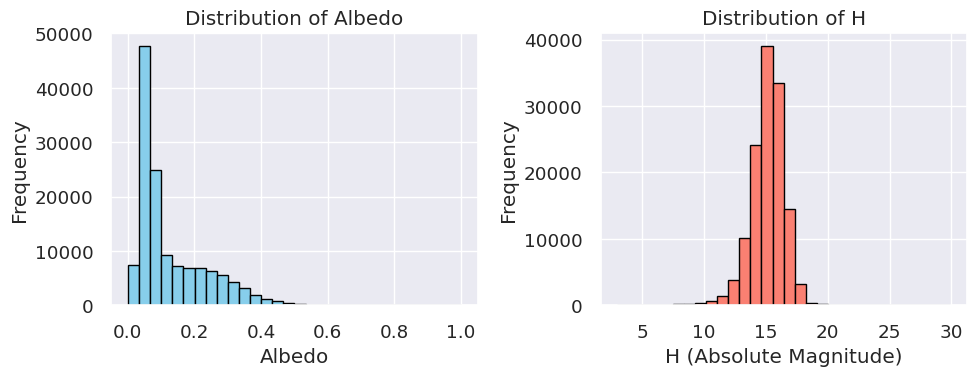

In [18]:
import matplotlib.pyplot as plt

# Histogram for albedo
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df_regression['Reflectivity'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Albedo')
plt.xlabel('Albedo')
plt.ylabel('Frequency')

# Histogram for H
plt.subplot(1, 2, 2)
plt.hist(df_regression['Brightness'].dropna(), bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of H')
plt.xlabel('H (Absolute Magnitude)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [19]:
df_regression[['Brightness', 'Reflectivity']].describe()

Brightness   Reflectivity
count  132045.000000  135100.000000
mean       15.132319       0.130625
std         1.387944       0.110323
min         3.000000       0.001000
25%        14.400000       0.053000
50%        15.200000       0.079000
75%        16.000000       0.190000
max        29.900000       1.000000

In [20]:
#df_regression = df_regression.copy()
df_regression['Reflectivity'] = df_regression['Reflectivity'].fillna(df_regression['Reflectivity'].median())
df_regression['Brightness'] = df_regression['Brightness'].fillna(df_regression['Brightness'].mean())



/tmp/ipython-input-20-224784250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression['Reflectivity'] = df_regression['Reflectivity'].fillna(df_regression['Reflectivity'].median())
/tmp/ipython-input-20-224784250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression['Brightness'] = df_regression['Brightness'].fillna(df_regression['Brightness'].mean())


In [21]:
df_regression[['Brightness', 'Reflectivity']].describe()

Brightness   Reflectivity
count  136209.000000  136209.000000
mean       15.132319       0.130205
std         1.366564       0.109971
min         3.000000       0.001000
25%        14.400000       0.053000
50%        15.200000       0.079000
75%        16.000000       0.188000
max        29.900000       1.000000

In [22]:
df_regression.isnull().sum()

Near_Earth_Object               0
Potentially_Hazardous           0
Brightness                      0
Asteroid_Size_km(Diameter)      0
Reflectivity                    0
Orbit_Shape                     0
Orbit_Distance_AU               0
Closest_Sun_Distance_AU         0
Orbit_Tilt_Degrees              0
Orbit_Angle_1_Degrees           0
Orbit_Angle_2_Degrees           0
Orbit_Angle_3_Degrees           0
Farthest_Sun_Distance_AU        0
Orbit_Speed_Degrees_Per_Day     0
Orbit_Period_Days               0
Orbit_Period_Years              0
Earth_Closest_Distance_AU       0
Earth_Closest_Distance_Lunar    0
Asteroid_Class                  0
dtype: int64

# Visualization of Classification Dataset

In [23]:
# Identify numerical and categorical columns

TARGET_class = 'Potentially_Hazardous'
numerical_cols_c = df_classification.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols_c = df_classification.select_dtypes(include=['object', 'bool']).columns.tolist()
print(f"{len(numerical_cols_c)} Numerical Features: {numerical_cols_c}")
print(f"{len(categorical_cols_c)} Categorical Features: {categorical_cols_c}")


14 Numerical Features: ['Brightness', 'Orbit_Shape', 'Orbit_Distance_AU', 'Closest_Sun_Distance_AU', 'Orbit_Tilt_Degrees', 'Orbit_Angle_1_Degrees', 'Orbit_Angle_2_Degrees', 'Orbit_Angle_3_Degrees', 'Farthest_Sun_Distance_AU', 'Orbit_Speed_Degrees_Per_Day', 'Orbit_Period_Days', 'Orbit_Period_Years', 'Earth_Closest_Distance_AU', 'Earth_Closest_Distance_Lunar']
3 Categorical Features: ['Near_Earth_Object', 'Potentially_Hazardous', 'Asteroid_Class']


In [24]:
df_classification.describe()

Brightness    Orbit_Shape  Orbit_Distance_AU  \
count  932336.000000  932336.000000      932336.000000   
mean       16.889991       0.156221           2.932615   
std         1.801331       0.093001          36.458214   
min        -1.100000       0.000003           0.555418   
25%        16.000000       0.092160           2.389088   
50%        16.900000       0.144933           2.647971   
75%        17.700000       0.200589           3.002982   
max        33.200000       0.999851       33488.895955   

       Closest_Sun_Distance_AU  Orbit_Tilt_Degrees  Orbit_Angle_1_Degrees  \
count            932336.000000       932336.000000          932336.000000   
mean                  2.398918            8.996694             168.395442   
std                   2.165336            6.606941             102.863946   
min                   0.070511            0.007744               0.000025   
25%                   1.972209            4.135564              80.528080   
50%                   2.227214            7.357849             159.871025   
75%                   2.580131           12.332727             251.974334   
max                  80.398819          175.082901             359.999793   

       Orbit_Angle_2_Degrees  Orbit_Angle_3_Degrees  Farthest_Sun_Distance_AU  \
count          932336.000000          932336.000000             932336.000000   
mean              181.381454             177.029125                  3.466313   
std               103.909981             105.755423                 72.768214   
min                 0.000130             -67.136826                  0.653773   
25%                91.490778              83.559427                  2.783887   
50%               182.353517             174.966318                  3.048694   
75%               271.551530             269.594056                  3.365570   
max               359.999646             491.618014              66972.796064   

       Orbit_Speed_Degrees_Per_Day  Orbit_Period_Days  Orbit_Period_Years  \
count                 9.323360e+05       9.323360e+05        9.323360e+05   
mean                  2.366077e-01       5.181153e+03        1.418522e+01   
std                   7.998690e-02       2.341159e+06        6.409743e+03   
min                   1.608247e-07       1.511918e+02        4.139405e-01   
25%                   1.893978e-01       1.348797e+03        3.692806e+00   
50%                   2.287358e-01       1.573868e+03        4.309016e+00   
75%                   2.669044e-01       1.900761e+03        5.204001e+00   
max                   2.381082e+00       2.238462e+09        6.128574e+06   

       Earth_Closest_Distance_AU  Earth_Closest_Distance_Lunar  
count               9.323360e+05                 932336.000000  
mean                1.416253e+00                    551.163122  
std                 2.162694e+00                    841.655463  
min                 4.544120e-07                      0.000177  
25%                 9.802075e-01                    381.467353  
50%                 1.241285e+00                    483.070883  
75%                 1.593700e+00                    620.220229  
max                 7.947660e+01                  30929.908422

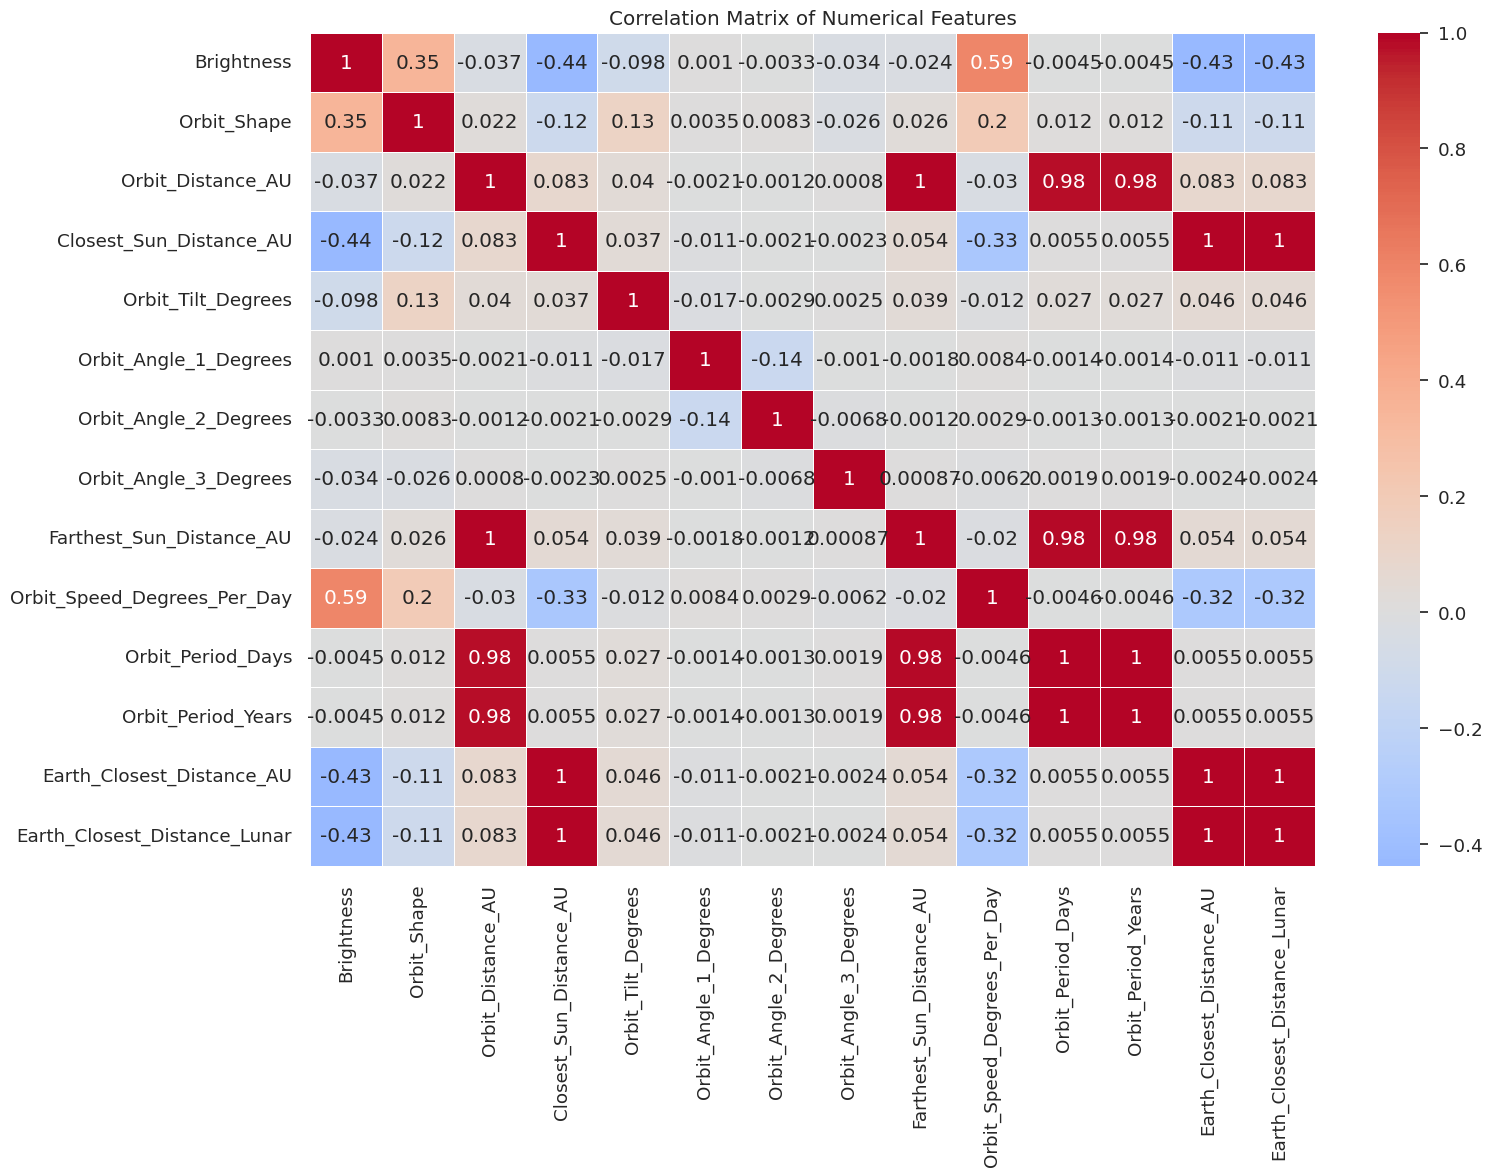

In [25]:
plt.figure(figsize=(16, 12))
correlation_matrix = df_classification[numerical_cols_c].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.savefig("class_correlation_matrix_heatmap.png", dpi=300, bbox_inches='tight')

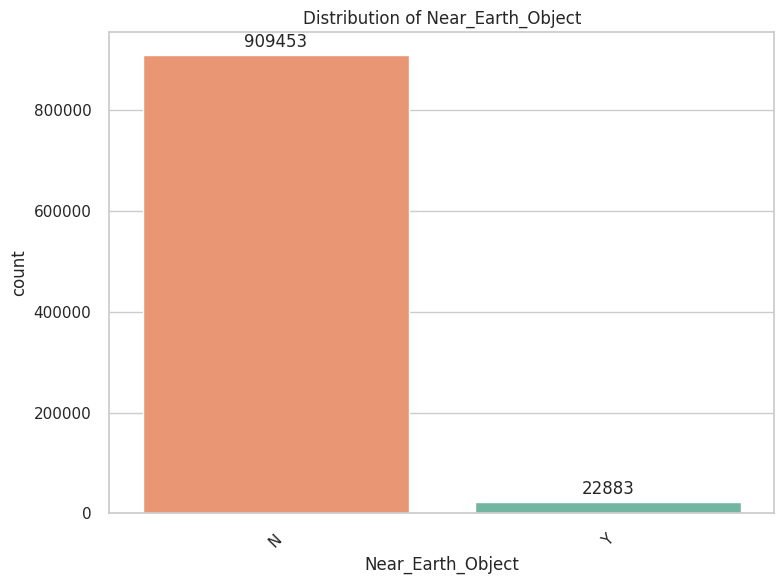

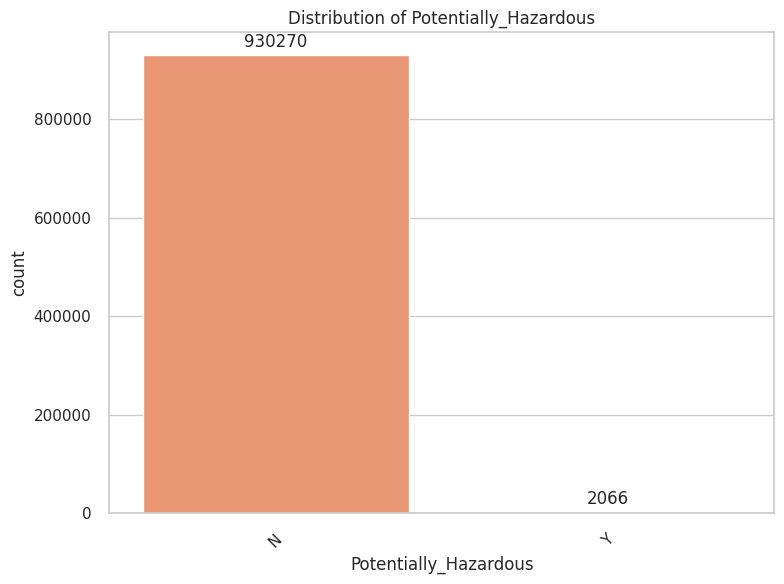

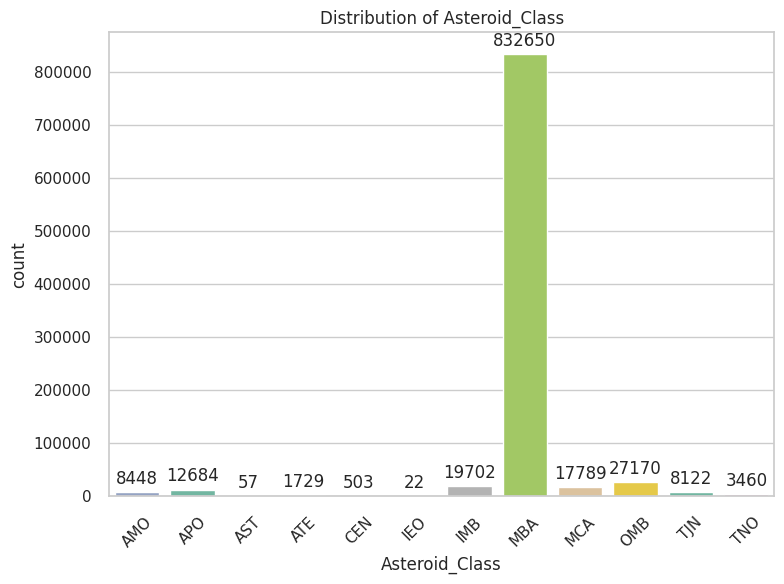

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Barcharts of categorical features in the classification dataset
sns.set(style="whitegrid")

for col in categorical_cols_c:
    order = sorted(df_classification[col].dropna().unique())
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(data=df_classification, x=col, hue=col, order=order, palette="Set2", legend=False)

    # Add number labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"Distribution of {col}.png", dpi=300, bbox_inches='tight')
    plt.show()


In [28]:
df_regression.describe()

Brightness  Asteroid_Size_km(Diameter)   Reflectivity  \
count  136209.000000               136209.000000  136209.000000   
mean       15.132319                    5.506429       0.130205   
std         1.366564                    9.425164       0.109971   
min         3.000000                    0.002500       0.001000   
25%        14.400000                    2.780000       0.053000   
50%        15.200000                    3.972000       0.079000   
75%        16.000000                    5.765000       0.188000   
max        29.900000                  939.400000       1.000000   

         Orbit_Shape  Orbit_Distance_AU  Closest_Sun_Distance_AU  \
count  136209.000000      136209.000000            136209.000000   
mean        0.145660           2.819158                 2.406130   
std         0.077464           1.495980                 0.516931   
min         0.000060           0.626210                 0.081820   
25%         0.089878           2.542856                 2.072478   
50%         0.138919           2.754950                 2.368605   
75%         0.191174           3.095029                 2.688275   
max         0.983789         376.133297                40.318477   

       Orbit_Tilt_Degrees  Orbit_Angle_1_Degrees  Orbit_Angle_2_Degrees  \
count       136209.000000          136209.000000          136209.000000   
mean            10.295360             169.729893             181.808169   
std              6.812632             102.715175             103.516287   
min              0.022056               0.000418               0.000130   
25%              5.088142              82.276476              91.903488   
50%              9.335690             160.301343             183.509496   
75%             13.670331             255.961202             271.642281   
max            170.334595             359.999793             359.998075   

       Orbit_Angle_3_Degrees  Farthest_Sun_Distance_AU  \
count          136209.000000             136209.000000   
mean              184.529202                  3.232187   
std               105.632553                  2.839820   
min                 0.005112                  0.999954   
25%                91.647097                  2.871056   
50%               188.275290                  3.173515   
75%               277.821001                  3.472570   
max               391.682098                746.169105   

       Orbit_Speed_Degrees_Per_Day  Orbit_Period_Days  Orbit_Period_Years  \
count                136209.000000       1.362090e+05       136209.000000   
mean                      0.219086       1.787231e+03            4.893173   
std                       0.056912       8.965840e+03           24.547132   
min                       0.000135       1.809999e+02            0.495551   
25%                       0.181012       1.481089e+03            4.055000   
50%                       0.215543       1.670202e+03            4.572764   
75%                       0.243064       1.988820e+03            5.445092   
max                       1.988951       2.664472e+06         7294.925719   

       Earth_Closest_Distance_AU  Earth_Closest_Distance_Lunar  
count              136209.000000                 136209.000000  
mean                    1.423858                    554.122719  
std                     0.513029                    199.655301  
min                     0.000027                      0.010335  
25%                     1.086220                    422.724237  
50%                     1.389580                    540.782849  
75%                     1.702400                    662.523008  
max                    39.360300                  15317.847951

/tmp/ipython-input-29-1362953677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")


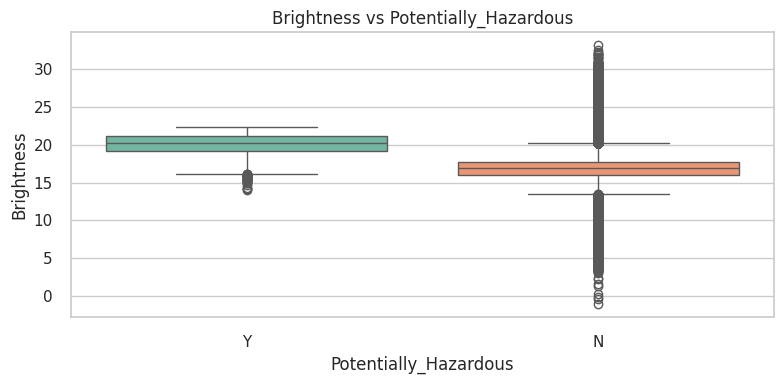

/tmp/ipython-input-29-1362953677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")


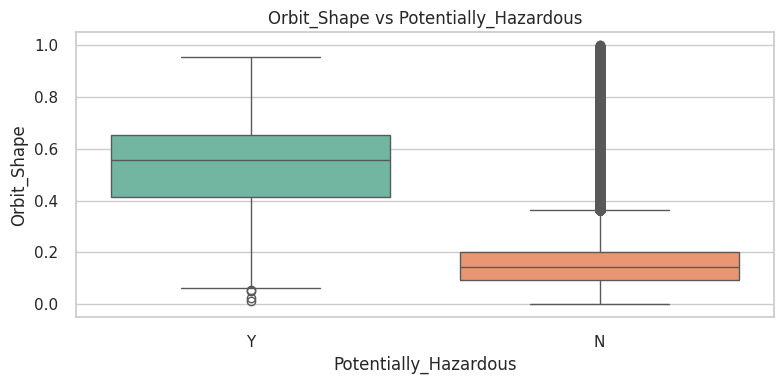

/tmp/ipython-input-29-1362953677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")


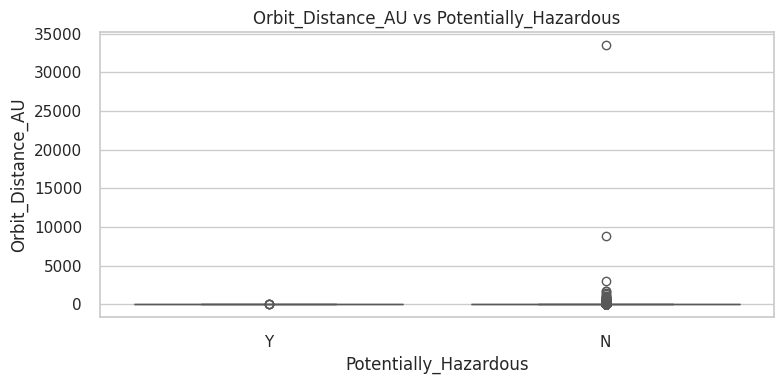

/tmp/ipython-input-29-1362953677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")


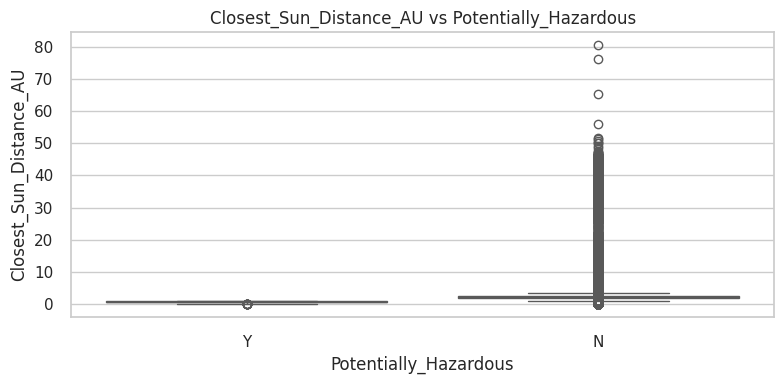

/tmp/ipython-input-29-1362953677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")


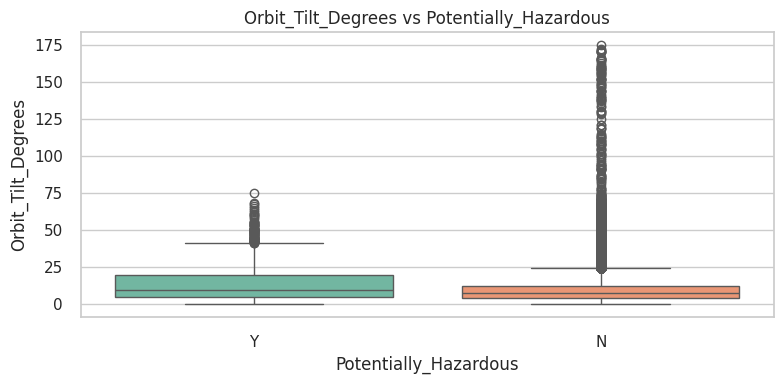

/tmp/ipython-input-29-1362953677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")


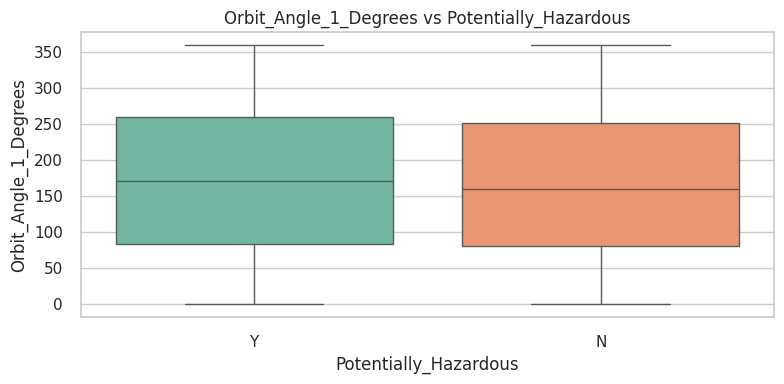

/tmp/ipython-input-29-1362953677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")


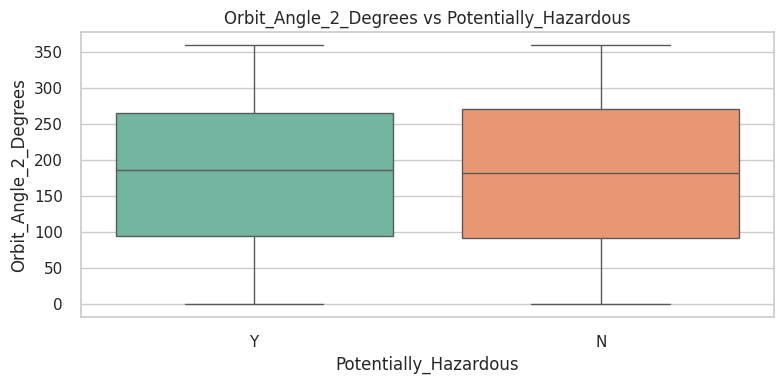

/tmp/ipython-input-29-1362953677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")


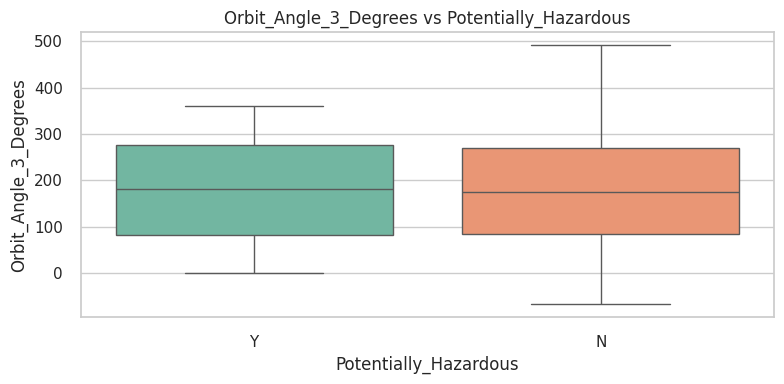

/tmp/ipython-input-29-1362953677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")


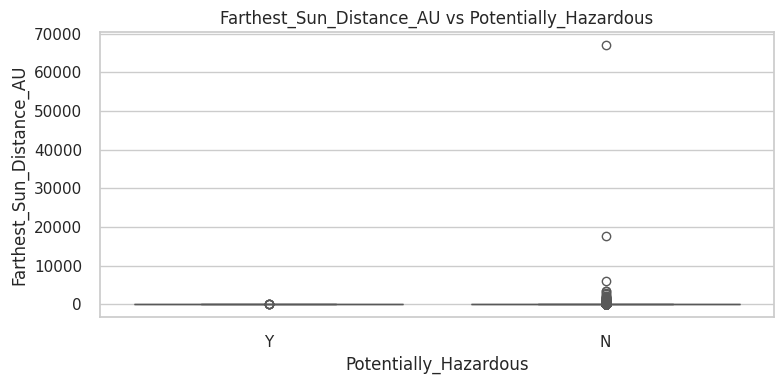

/tmp/ipython-input-29-1362953677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")


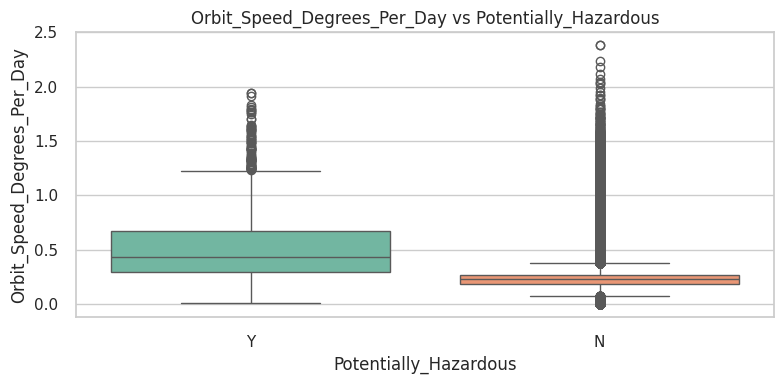

/tmp/ipython-input-29-1362953677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")


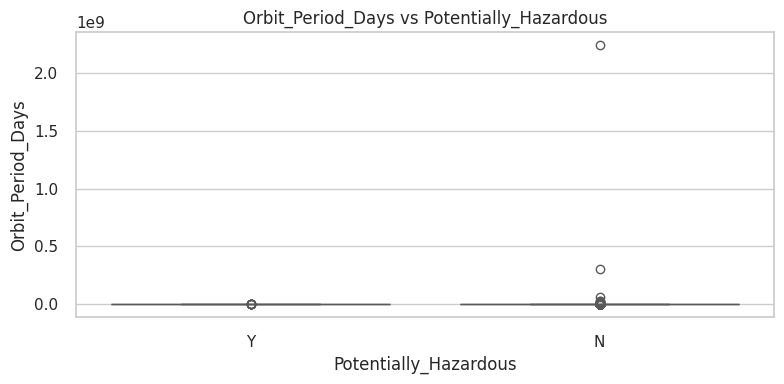

/tmp/ipython-input-29-1362953677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")


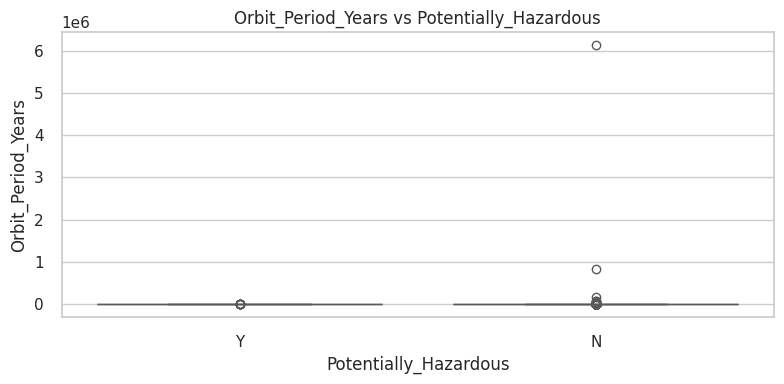

/tmp/ipython-input-29-1362953677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")


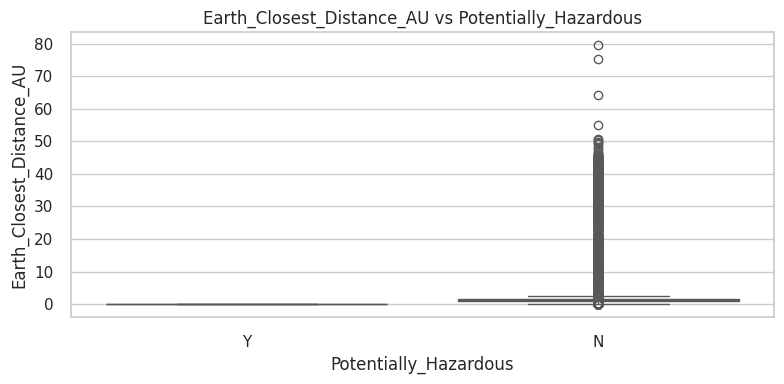

/tmp/ipython-input-29-1362953677.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")


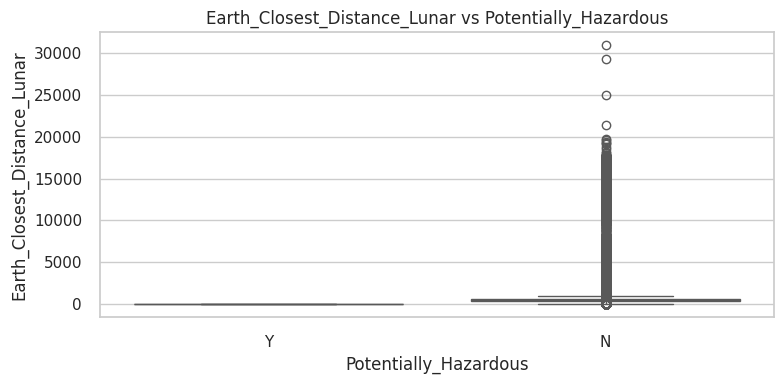

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create boxplots for each numerical feature vs the target
for col in numerical_cols_c:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_classification, x=TARGET_class, y=col, palette="Set2")
    plt.title(f"{col} vs {TARGET_class}")
    plt.xlabel(TARGET_class)
    plt.ylabel(col)
    plt.tight_layout()
    plt.savefig(f"{col}_vs_{TARGET_class}.png", dpi=300, bbox_inches='tight')
    plt.show()


# Visualization of Regression Dataset

In [30]:
TARGET_reg = 'Asteroid_Size_km(Diameter)'

numerical_cols_r = df_regression.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols_r = df_regression.select_dtypes(include=['object', 'bool']).columns.tolist()
print(f"Numerical Features: {numerical_cols_r}, {len(numerical_cols_r)}")
print(f"Categorical Features: {categorical_cols_r}, {len(categorical_cols_r)}")

Numerical Features: ['Brightness', 'Asteroid_Size_km(Diameter)', 'Reflectivity', 'Orbit_Shape', 'Orbit_Distance_AU', 'Closest_Sun_Distance_AU', 'Orbit_Tilt_Degrees', 'Orbit_Angle_1_Degrees', 'Orbit_Angle_2_Degrees', 'Orbit_Angle_3_Degrees', 'Farthest_Sun_Distance_AU', 'Orbit_Speed_Degrees_Per_Day', 'Orbit_Period_Days', 'Orbit_Period_Years', 'Earth_Closest_Distance_AU', 'Earth_Closest_Distance_Lunar'], 16
Categorical Features: ['Near_Earth_Object', 'Potentially_Hazardous', 'Asteroid_Class'], 3


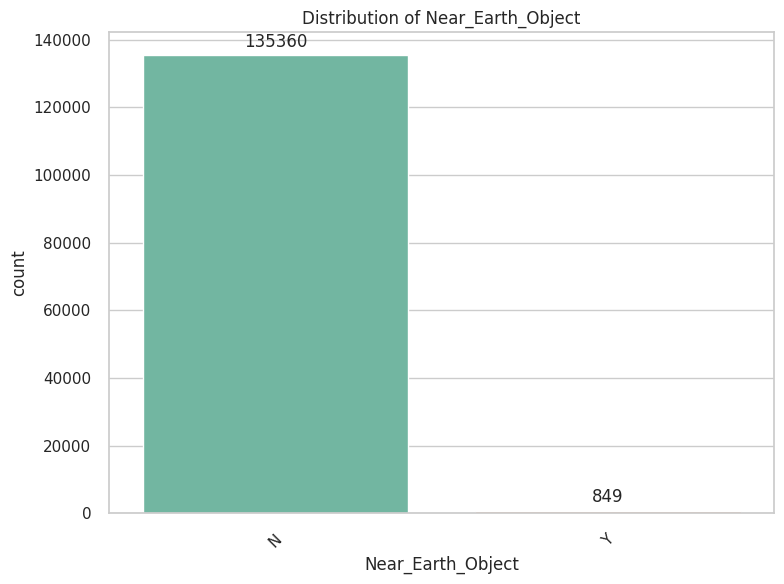

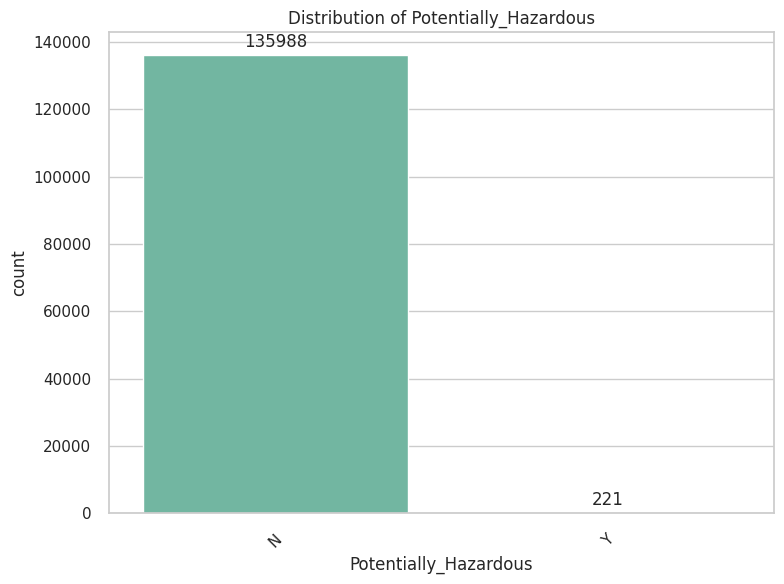

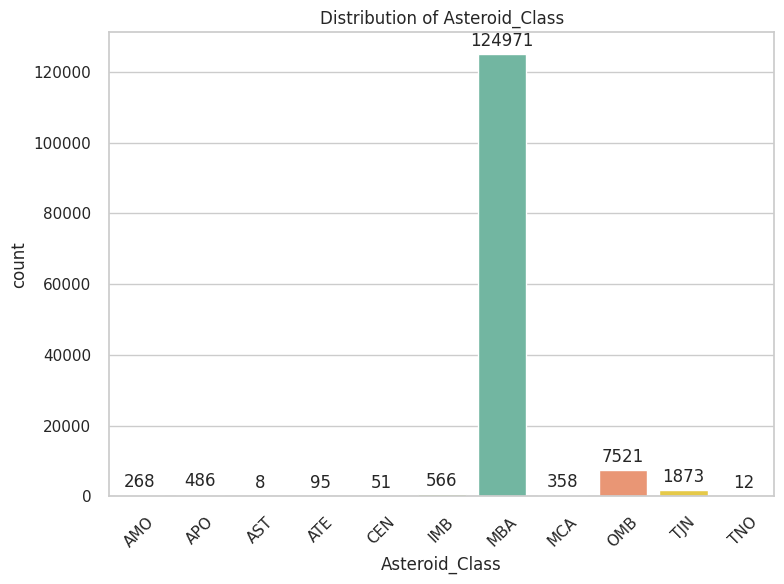

In [31]:
# Barcharts of categorical features in the regression dataset

for col in categorical_cols_r:
    order = sorted(df_regression[col].dropna().unique())
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(data=df_regression, x=col, hue=col, order=order, palette="Set2", legend=False)

    # Add number labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"Distribution of {col}.png", dpi=300, bbox_inches='tight')
    #plt.show()


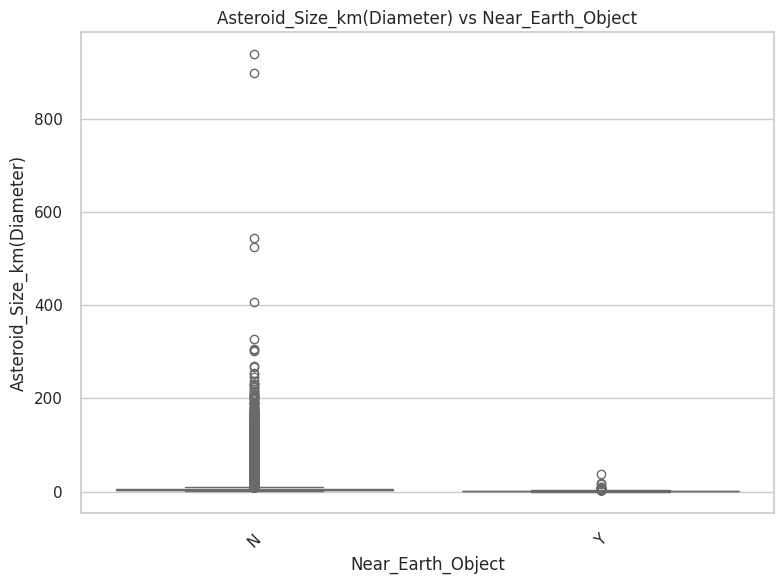

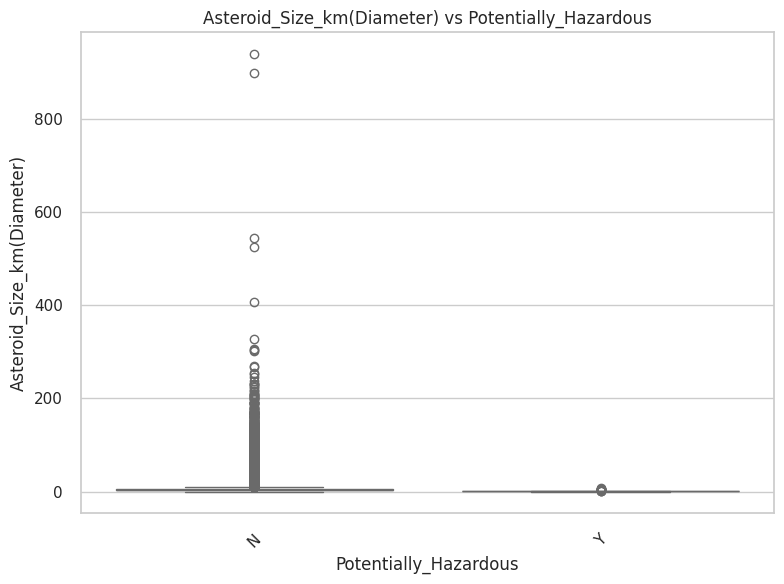

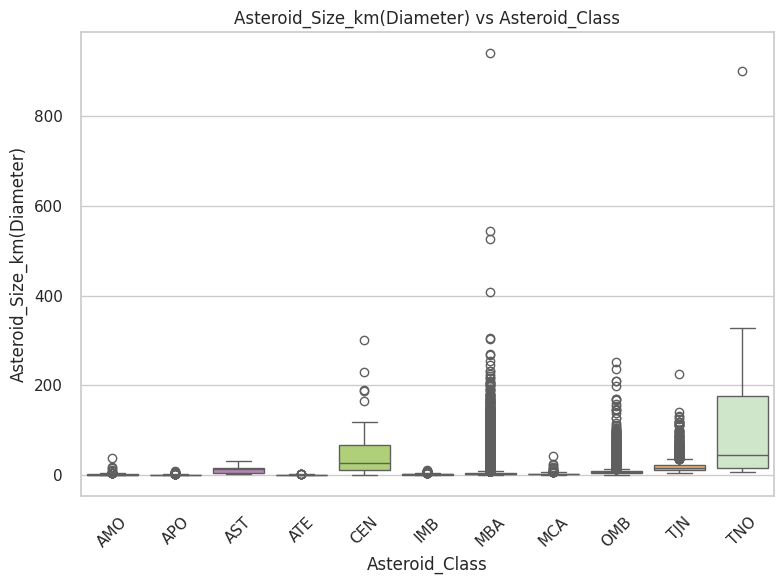

In [32]:
# Boxplots of Categorical Features vs TARGET_reg

for col in categorical_cols_r:
    order = sorted(df_regression[col].dropna().unique())  # or specify a custom list

    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_regression, x=col, y=TARGET_reg, hue=col, order=order, palette="Set3")
    plt.title(f'{TARGET_reg} vs {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"boxplot_{TARGET_reg} vs {col}.png", dpi=300, bbox_inches='tight')
    plt.show()


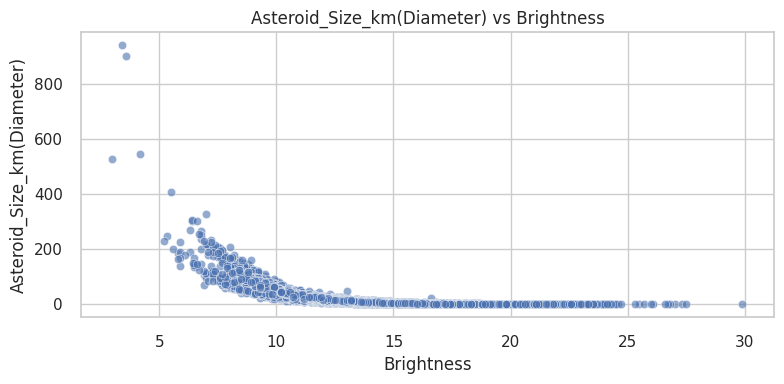

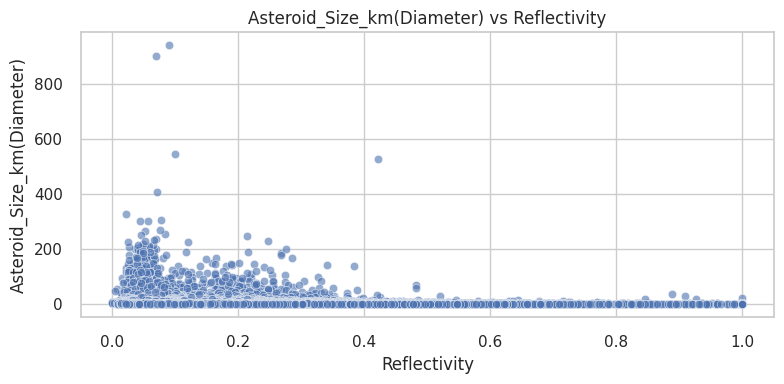

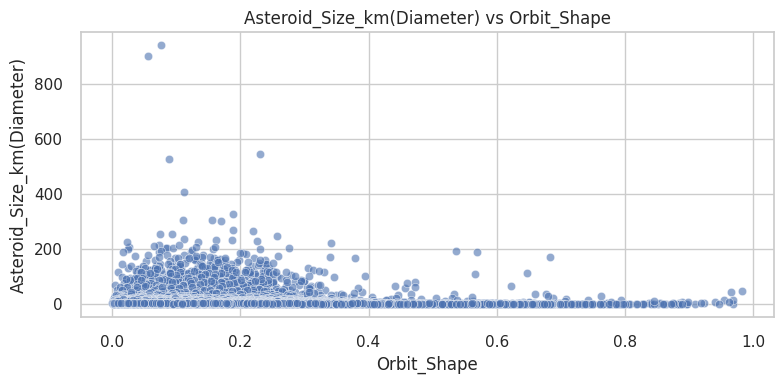

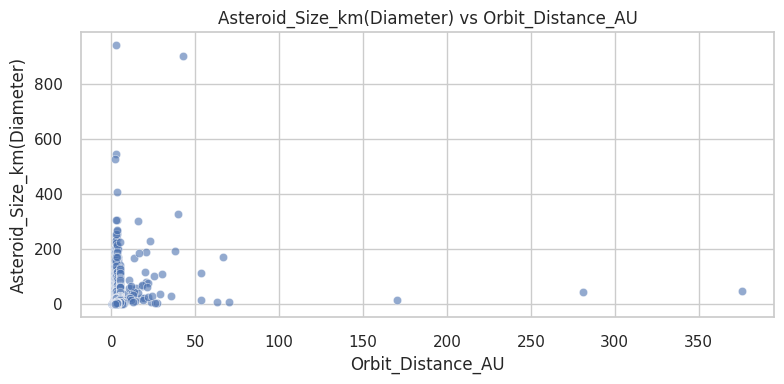

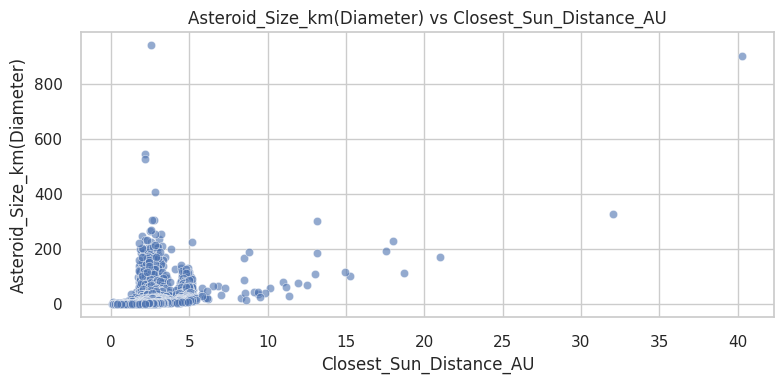

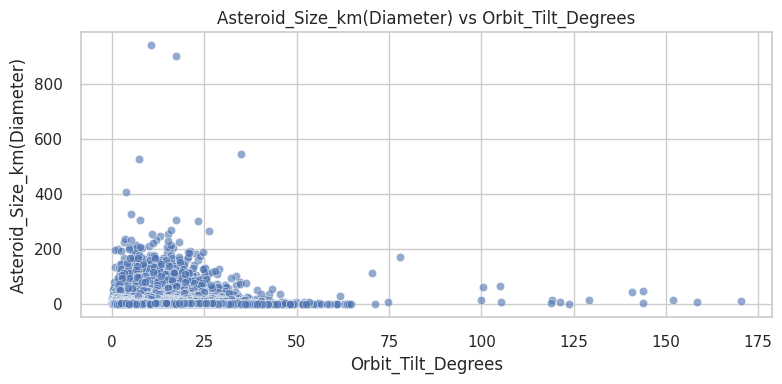

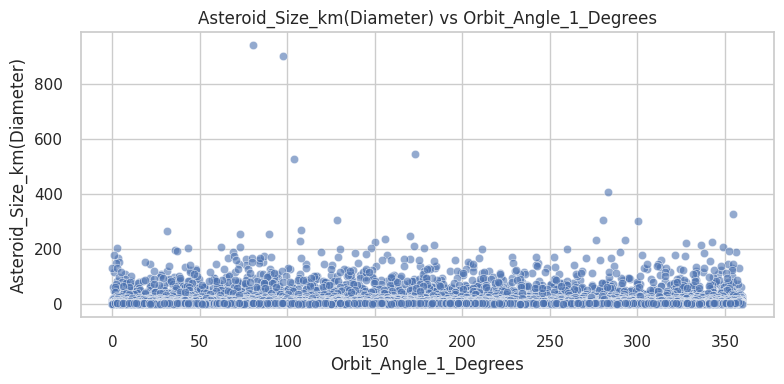

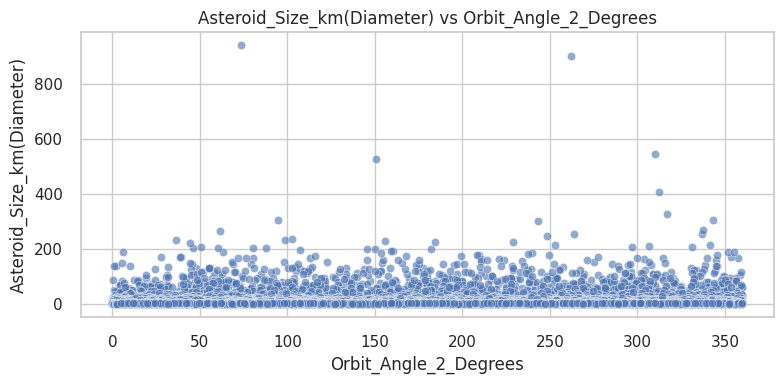

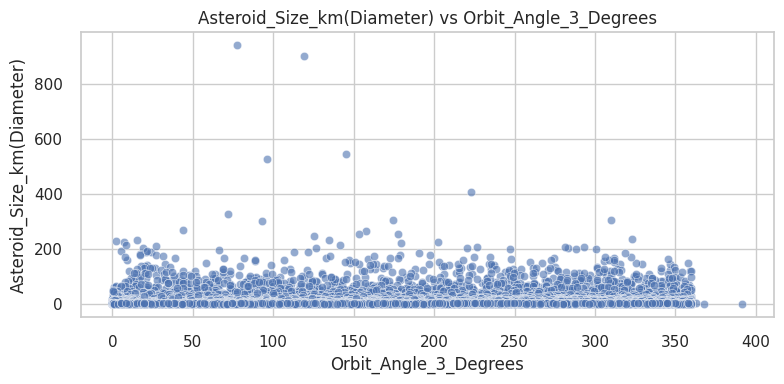

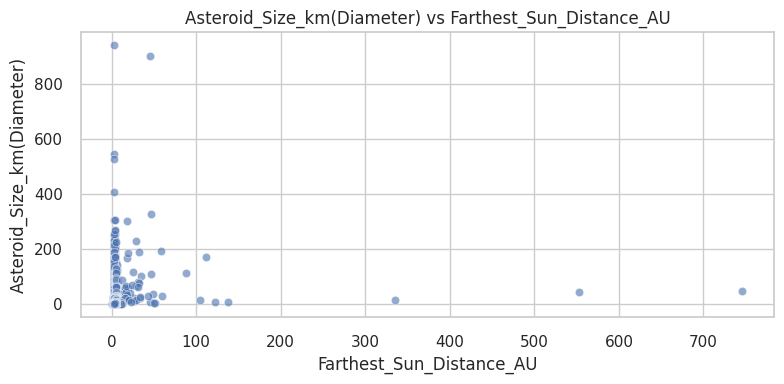

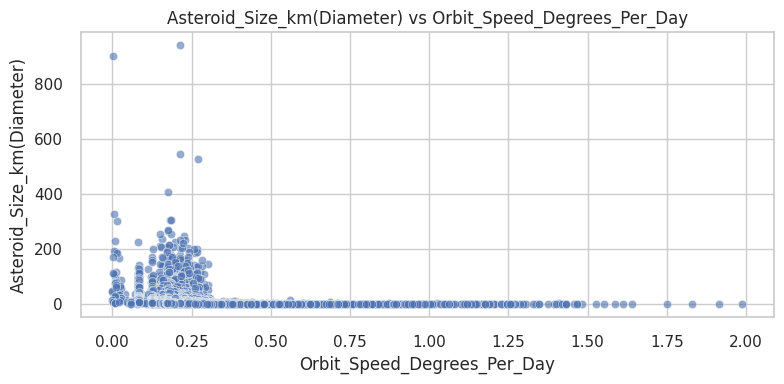

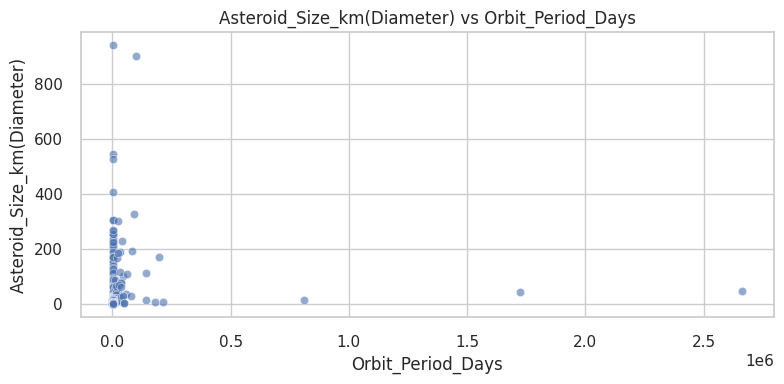

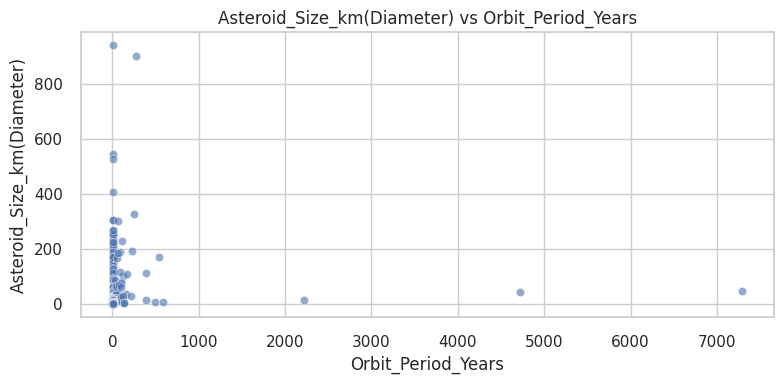

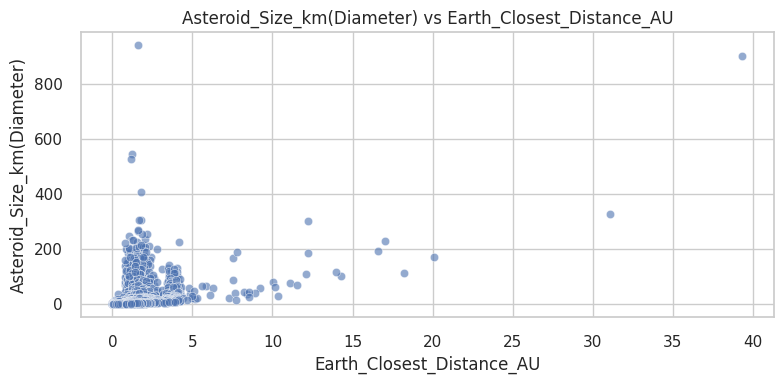

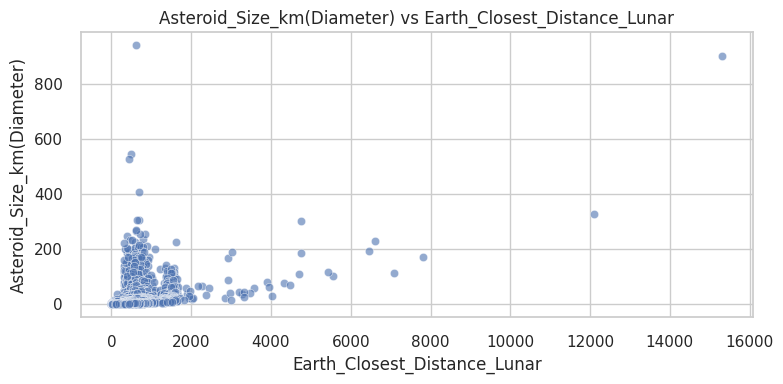

In [33]:
# Scatter Plots of Numerical Features vs TARGET_reg
for col in numerical_cols_r:
    if col != TARGET_reg:
        plt.figure(figsize=(8, 4))
        sns.scatterplot(data=df_regression, x=col, y=TARGET_reg, alpha=0.6)
        plt.title(f'{TARGET_reg} vs {col}')
        plt.tight_layout()
        plt.savefig(f"scatter_{TARGET_reg} vs {col}.png", dpi=300, bbox_inches='tight')
        plt.show()


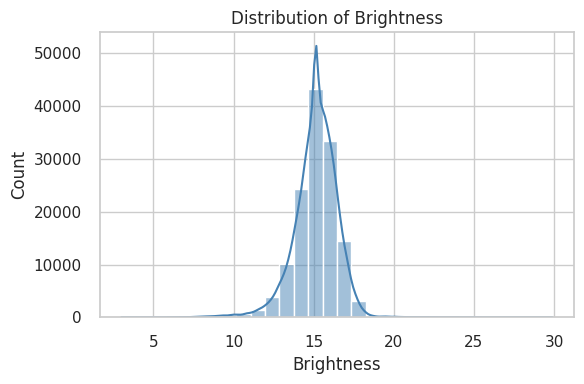

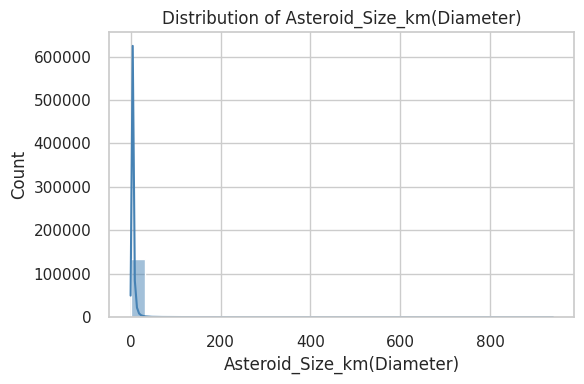

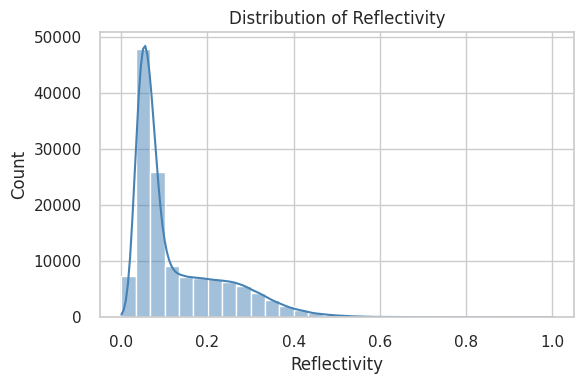

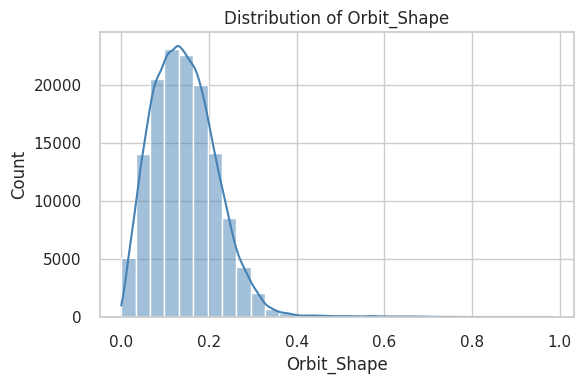

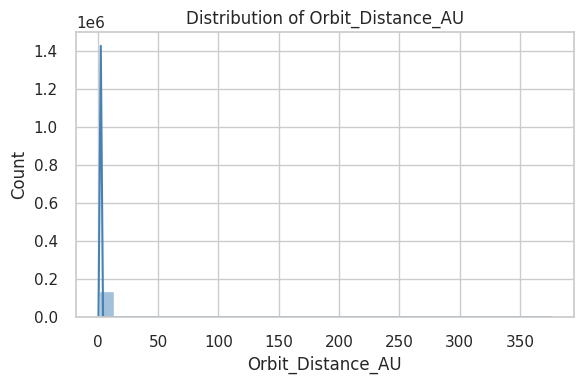

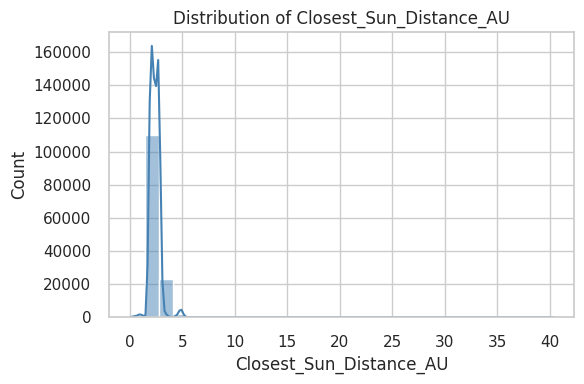

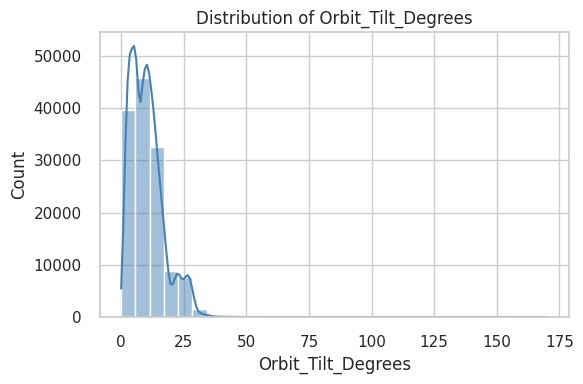

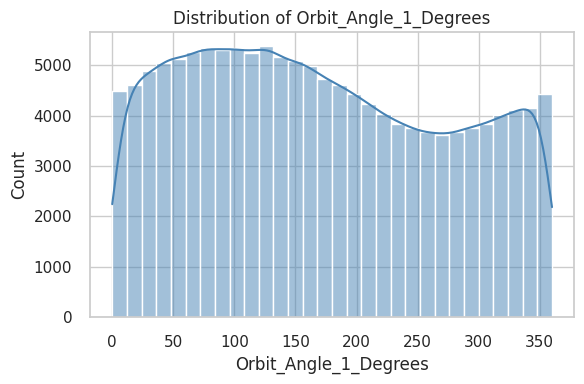

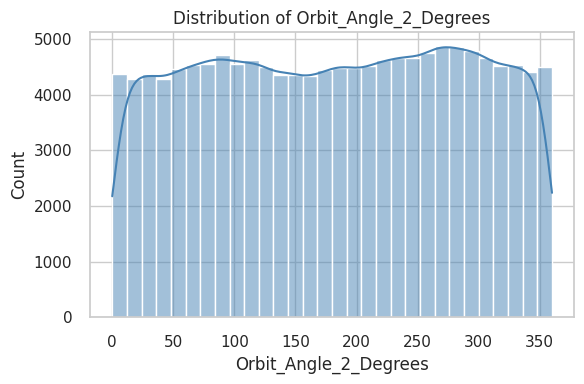

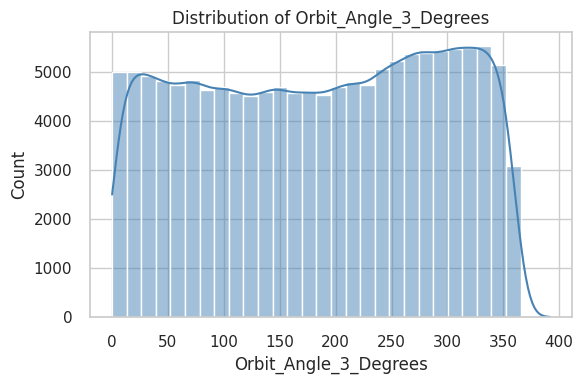

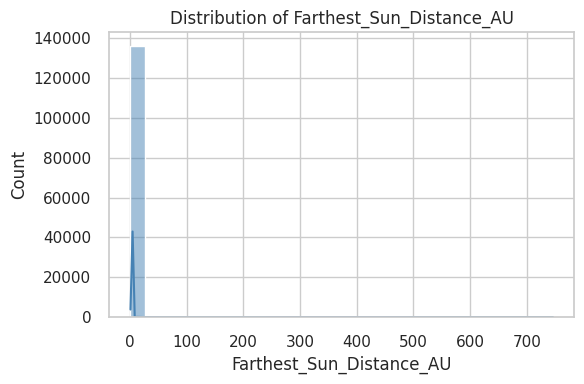

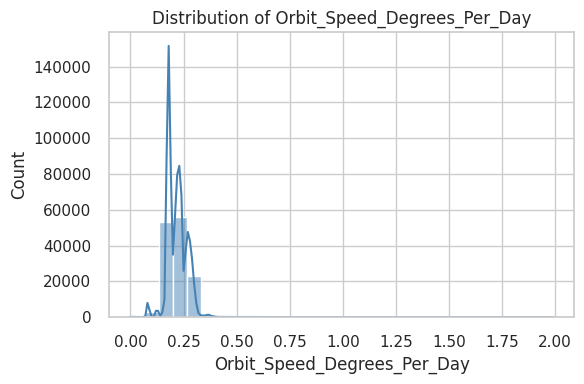

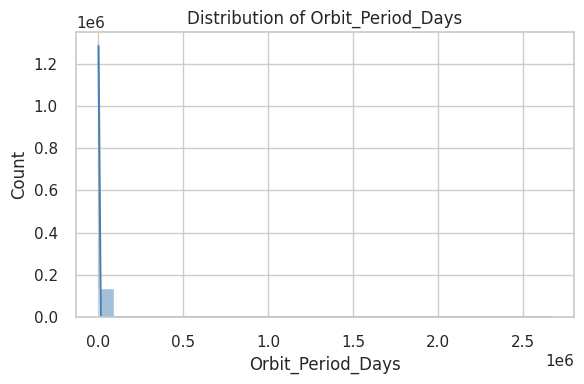

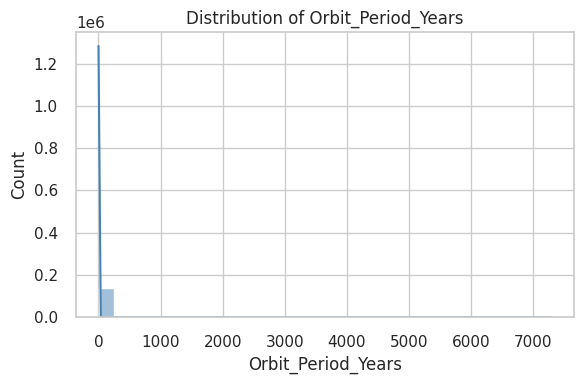

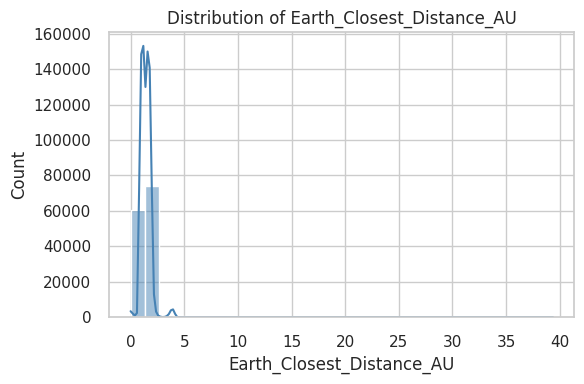

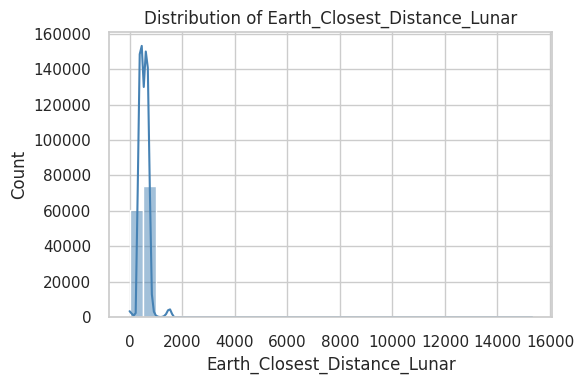

In [34]:
# Histograms of Numerical Variables

for col in numerical_cols_r:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df_regression, x=col, kde=True, bins=30, color='steelblue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.savefig(f"hist_{TARGET_reg} vs {col}.png", dpi=300, bbox_inches='tight')
    plt.show()


count         mean          std         min  \
Brightness                    136209.0    15.132319     1.366564    3.000000   
Asteroid_Size_km(Diameter)    136209.0     5.506429     9.425164    0.002500   
Reflectivity                  136209.0     0.130205     0.109971    0.001000   
Orbit_Shape                   136209.0     0.145660     0.077464    0.000060   
Orbit_Distance_AU             136209.0     2.819158     1.495980    0.626210   
Closest_Sun_Distance_AU       136209.0     2.406130     0.516931    0.081820   
Orbit_Tilt_Degrees            136209.0    10.295360     6.812632    0.022056   
Orbit_Angle_1_Degrees         136209.0   169.729893   102.715175    0.000418   
Orbit_Angle_2_Degrees         136209.0   181.808169   103.516287    0.000130   
Orbit_Angle_3_Degrees         136209.0   184.529202   105.632553    0.005112   
Farthest_Sun_Distance_AU      136209.0     3.232187     2.839820    0.999954   
Orbit_Speed_Degrees_Per_Day   136209.0     0.219086     0.056912    0.000135   
Orbit_Period_Days             136209.0  1787.231375  8965.839867  180.999945   
Orbit_Period_Years            136209.0     4.893173    24.547132    0.495551   
Earth_Closest_Distance_AU     136209.0     1.423858     0.513029    0.000027   
Earth_Closest_Distance_Lunar  136209.0   554.122719   199.655301    0.010335   

                                      25%          50%          75%  \
Brightness                      14.400000    15.200000    16.000000   
Asteroid_Size_km(Diameter)       2.780000     3.972000     5.765000   
Reflectivity                     0.053000     0.079000     0.188000   
Orbit_Shape                      0.089878     0.138919     0.191174   
Orbit_Distance_AU                2.542856     2.754950     3.095029   
Closest_Sun_Distance_AU          2.072478     2.368605     2.688275   
Orbit_Tilt_Degrees               5.088142     9.335690    13.670331   
Orbit_Angle_1_Degrees           82.276476   160.301343   255.961202   
Orbit_Angle_2_Degrees           91.903488   183.509496   271.642281   
Orbit_Angle_3_Degrees           91.647097   188.275290   277.821001   
Farthest_Sun_Distance_AU         2.871056     3.173515     3.472570   
Orbit_Speed_Degrees_Per_Day      0.181012     0.215543     0.243064   
Orbit_Period_Days             1481.088579  1670.202045  1988.819671   
Orbit_Period_Years               4.055000     4.572764     5.445092   
Earth_Closest_Distance_AU        1.086220     1.389580     1.702400   
Earth_Closest_Distance_Lunar   422.724237   540.782849   662.523008   

                                       max    skewness      kurtosis  
Brightness                    2.990000e+01   -0.698152      4.370548  
Asteroid_Size_km(Diameter)    9.394000e+02   25.852418   1634.363104  
Reflectivity                  1.000000e+00    1.696635      3.958674  
Orbit_Shape                   9.837890e-01    1.407371      7.034553  
Orbit_Distance_AU             3.761333e+02  174.781076  38523.918438  
Closest_Sun_Distance_AU       4.031848e+01    7.314837    344.145509  
Orbit_Tilt_Degrees            1.703346e+02    1.659299     13.411315  
Orbit_Angle_1_Degrees         3.599998e+02    0.185611     -1.131491  
Orbit_Angle_2_Degrees         3.599981e+02   -0.027659     -1.203463  
Orbit_Angle_3_Degrees         3.916821e+02   -0.069455     -1.241824  
Farthest_Sun_Distance_AU      7.461691e+02  199.089250  46160.418336  
Orbit_Speed_Degrees_Per_Day   1.988951e+00    6.026977    106.752719  
Orbit_Period_Days             2.664472e+06  249.879621  67552.729860  
Orbit_Period_Years            7.294926e+03  249.879621  67552.729860  
Earth_Closest_Distance_AU     3.936030e+01    7.601012    356.071549  
Earth_Closest_Distance_Lunar  1.531785e+04    7.601012    356.071549

lower_bound  upper_bound  outlier_count  \
Brightness                      12.000000    18.400000         3532.0   
Asteroid_Size_km(Diameter)      -1.697500    10.242500         9613.0   
Reflectivity                    -0.149500     0.390500         3809.0   
Orbit_Shape                     -0.062066     0.343118         1503.0   
Orbit_Distance_AU                1.714597     3.923288         3423.0   
Closest_Sun_Distance_AU          1.148784     3.611970         2708.0   
Orbit_Tilt_Degrees              -7.785143    26.543616         4256.0   
Orbit_Angle_1_Degrees         -178.250614   516.488292            0.0   
Orbit_Angle_2_Degrees         -177.704700   541.250470            0.0   
Orbit_Angle_3_Degrees         -187.613758   557.081856            0.0   
Farthest_Sun_Distance_AU         1.968785     4.374841         3567.0   
Orbit_Speed_Degrees_Per_Day      0.087933     0.336143         3253.0   
Orbit_Period_Days              719.491942  2750.416309         3399.0   
Orbit_Period_Years               1.969862     7.530229         3399.0   
Earth_Closest_Distance_AU        0.161950     2.626670         2552.0   
Earth_Closest_Distance_Lunar    63.026081  1022.221164         2552.0   

                              outlier_percentage  
Brightness                                  2.59  
Asteroid_Size_km(Diameter)                  7.06  
Reflectivity                                2.80  
Orbit_Shape                                 1.10  
Orbit_Distance_AU                           2.51  
Closest_Sun_Distance_AU                     1.99  
Orbit_Tilt_Degrees                          3.12  
Orbit_Angle_1_Degrees                       0.00  
Orbit_Angle_2_Degrees                       0.00  
Orbit_Angle_3_Degrees                       0.00  
Farthest_Sun_Distance_AU                    2.62  
Orbit_Speed_Degrees_Per_Day                 2.39  
Orbit_Period_Days                           2.50  
Orbit_Period_Years                          2.50  
Earth_Closest_Distance_AU                   1.87  
Earth_Closest_Distance_Lunar                1.87

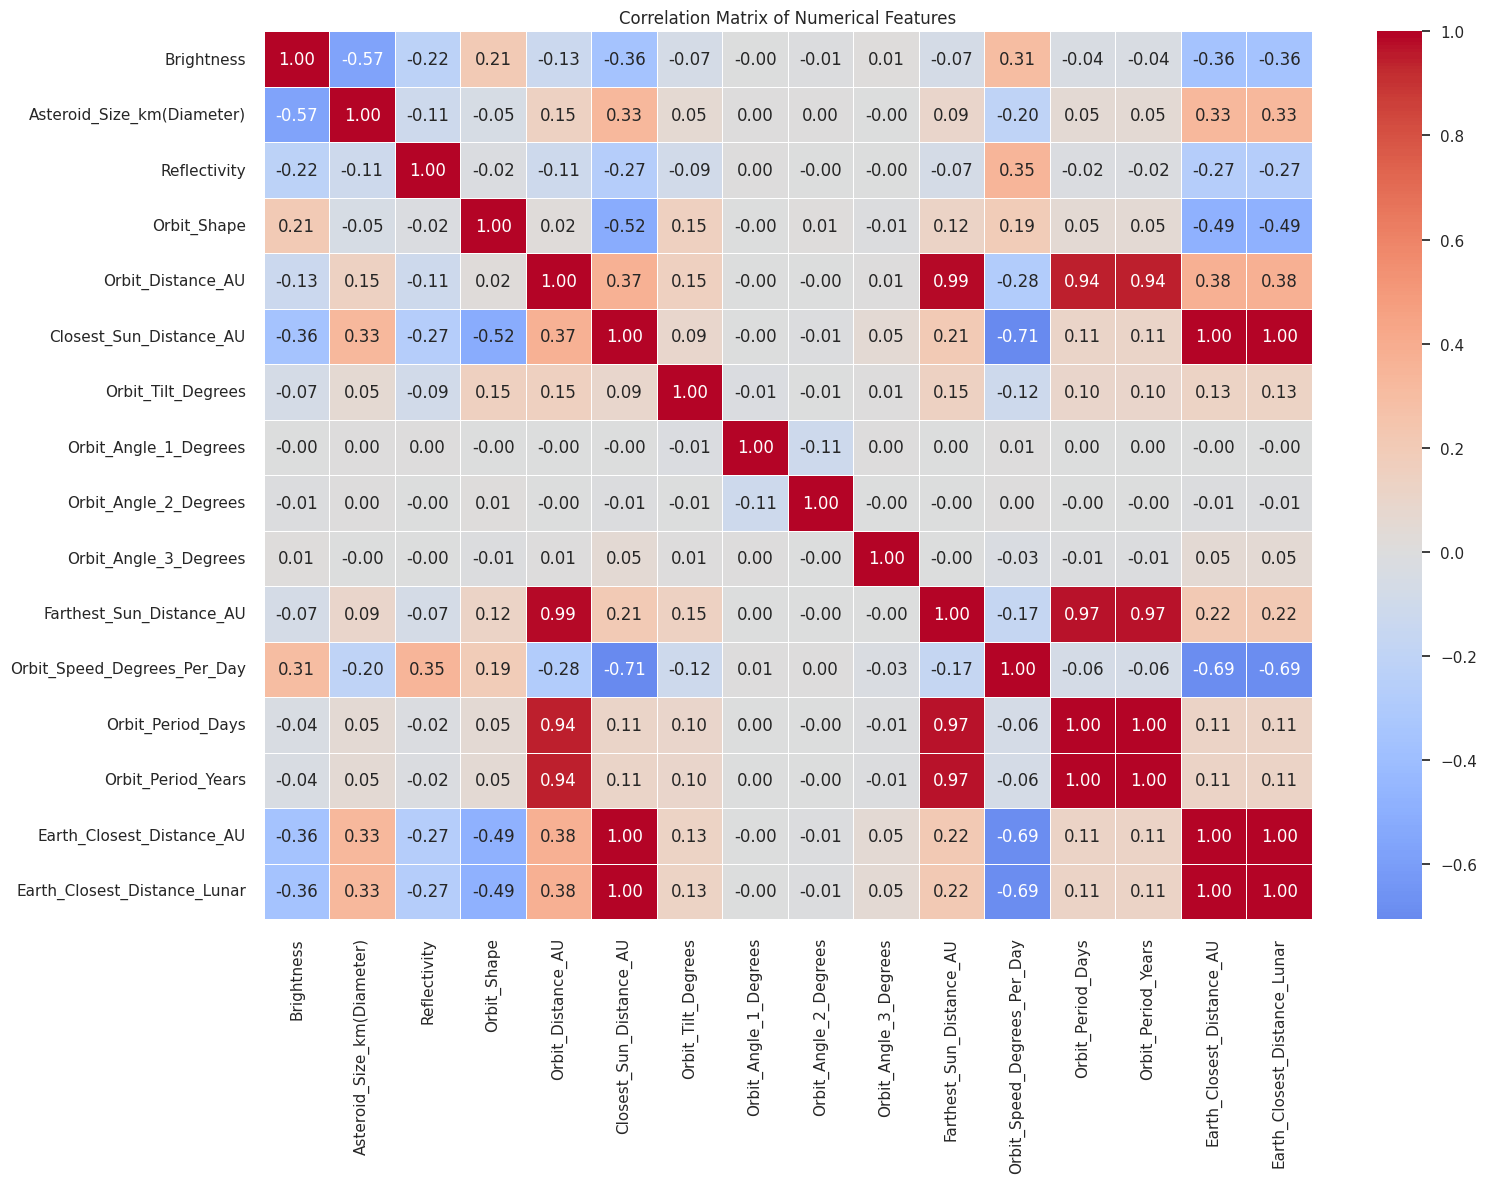

In [35]:
import pandas as pd

# Step 1: Numerical Summaries
summary_stats = df_regression[numerical_cols_r].describe().T
summary_stats['skewness'] = df_regression[numerical_cols_r].skew()
summary_stats['kurtosis'] = df_regression[numerical_cols_r].kurt()
display(summary_stats)

# Step 2: Corr Matrix
# Compute the correlation_matrix
plt.figure(figsize=(16, 12))
correlation_matrix = df_regression[numerical_cols_r].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.savefig("correlation_matrix_heatmap.png", dpi=300, bbox_inches='tight')
#plt.show()

# Step 3: Outlier Detection using IQR
outlier_summary = {}

for col in numerical_cols_r:
    Q1 = df_regression[col].quantile(0.25)
    Q3 = df_regression[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_regression[(df_regression[col] < lower_bound) | (df_regression[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_summary[col] = {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outlier_count': outlier_count,
        'outlier_percentage': round(outlier_count / len(df_regression) * 100, 2)
    }

# Convert to DataFrame for display
outlier_df = pd.DataFrame(outlier_summary).T
display(outlier_df)


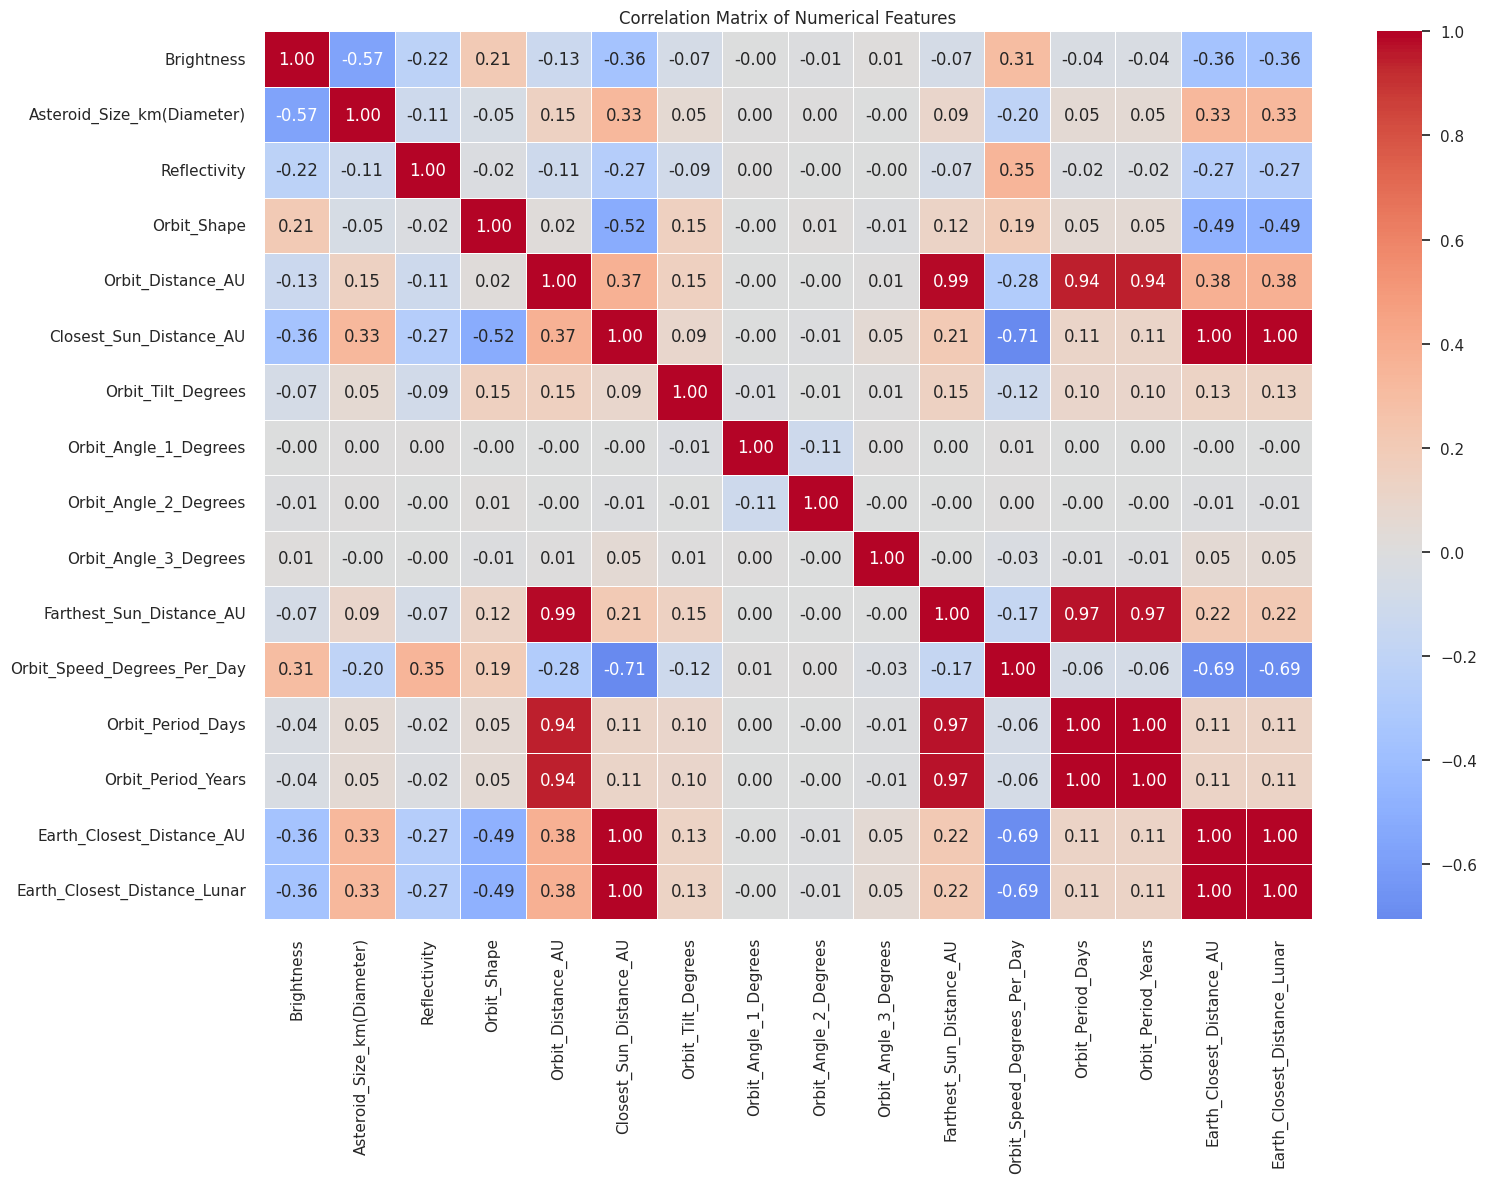

In [36]:
plt.figure(figsize=(16, 12))
correlation_matrix = df_regression[numerical_cols_r].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.savefig("correlation_matrix_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [37]:
df_classification.describe()

Brightness    Orbit_Shape  Orbit_Distance_AU  \
count  932336.000000  932336.000000      932336.000000   
mean       16.889991       0.156221           2.932615   
std         1.801331       0.093001          36.458214   
min        -1.100000       0.000003           0.555418   
25%        16.000000       0.092160           2.389088   
50%        16.900000       0.144933           2.647971   
75%        17.700000       0.200589           3.002982   
max        33.200000       0.999851       33488.895955   

       Closest_Sun_Distance_AU  Orbit_Tilt_Degrees  Orbit_Angle_1_Degrees  \
count            932336.000000       932336.000000          932336.000000   
mean                  2.398918            8.996694             168.395442   
std                   2.165336            6.606941             102.863946   
min                   0.070511            0.007744               0.000025   
25%                   1.972209            4.135564              80.528080   
50%                   2.227214            7.357849             159.871025   
75%                   2.580131           12.332727             251.974334   
max                  80.398819          175.082901             359.999793   

       Orbit_Angle_2_Degrees  Orbit_Angle_3_Degrees  Farthest_Sun_Distance_AU  \
count          932336.000000          932336.000000             932336.000000   
mean              181.381454             177.029125                  3.466313   
std               103.909981             105.755423                 72.768214   
min                 0.000130             -67.136826                  0.653773   
25%                91.490778              83.559427                  2.783887   
50%               182.353517             174.966318                  3.048694   
75%               271.551530             269.594056                  3.365570   
max               359.999646             491.618014              66972.796064   

       Orbit_Speed_Degrees_Per_Day  Orbit_Period_Days  Orbit_Period_Years  \
count                 9.323360e+05       9.323360e+05        9.323360e+05   
mean                  2.366077e-01       5.181153e+03        1.418522e+01   
std                   7.998690e-02       2.341159e+06        6.409743e+03   
min                   1.608247e-07       1.511918e+02        4.139405e-01   
25%                   1.893978e-01       1.348797e+03        3.692806e+00   
50%                   2.287358e-01       1.573868e+03        4.309016e+00   
75%                   2.669044e-01       1.900761e+03        5.204001e+00   
max                   2.381082e+00       2.238462e+09        6.128574e+06   

       Earth_Closest_Distance_AU  Earth_Closest_Distance_Lunar  
count               9.323360e+05                 932336.000000  
mean                1.416253e+00                    551.163122  
std                 2.162694e+00                    841.655463  
min                 4.544120e-07                      0.000177  
25%                 9.802075e-01                    381.467353  
50%                 1.241285e+00                    483.070883  
75%                 1.593700e+00                    620.220229  
max                 7.947660e+01                  30929.908422

## Inferential Statistics

### Classification

Point Biseral Correlation Between Potentially_Hazardous and Earth_Closest_Distance_AU

In [38]:
# Convert 'Y' to 1 and 'N' to 0
df_biseral = df_classification.copy()
df_biseral['Potentially_Hazardous'] = df_biseral['Potentially_Hazardous'].map({'Y': 1, 'N': 0})

In [39]:
from scipy.stats import pointbiserialr
r, p = pointbiserialr(df_biseral['Earth_Closest_Distance_AU'], df_biseral['Potentially_Hazardous'])
print(f"Point-Biserial Correlation: r = {r:.3f}, p = {p:.5f}")


Point-Biserial Correlation: r = -0.030, p = 0.00000


Conclusion: There is a statistically significant relationship. But r = -0.03 is so small, it has no practical (real-world) importance

Chi-Square Test between Asteroid_Class and Potentially_Hazardous

In [40]:
import pandas as pd
from scipy.stats import chi2_contingency

# Example: df has 'closest_distance_au' and 'hazardous' (0 or 1)
# Bin the distances into categories
print("""
H₀: Asteroid_Class category is independent of orbit Potentially_Hazardous category
H₁: Asteroid_Class category is dependent on Potentially_Hazardous category
""")
# Create a contingency table
contingency_table = pd.crosstab(df['Asteroid_Class'], df['Potentially_Hazardous'])
print("Contingency Table:\n", contingency_table)

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-Square Test:\nChi2 = {chi2:.3f}, p-value = {p:.5f}, dof = {dof}")



H₀: Asteroid_Class category is independent of orbit Potentially_Hazardous category
H₁: Asteroid_Class category is dependent on Potentially_Hazardous category

Contingency Table:
 Potentially_Hazardous       N     Y
Asteroid_Class                     
AMO                      8338   118
APO                     10919  1768
AST                        75     0
ATE                      1555   174
CEN                       504     0
HYA                         4     0
IEO                        16     6
IMB                     19903     0
MBA                    837430     0
MCA                     18356     0
OMB                     27815     0
TJN                      8160     0
TNO                      3462     0

Chi-Square Test:
Chi2 = 119576.736, p-value = 0.00000, dof = 12


Conclusion: Asteroid_Class is NOT independent of Potentially_Hazardous category.

### Regression

1-Way ANOVA: Asteroid Size vs Reflectivity


H₀: μ₁ = μ₂ = μ₃ (Mean reflectivity is the same across small, medium, and large asteroid groups)
H₁: At least one mean is different

Reflectivity_Group
Low Reflectivity       70150
High Reflectivity      33655
Medium Reflectivity    32404
Name: count, dtype: int64


/tmp/ipython-input-41-3909619770.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anova['Reflectivity_Group'] = pd.cut(df_anova['Reflectivity'], bins=bins, labels=labels)


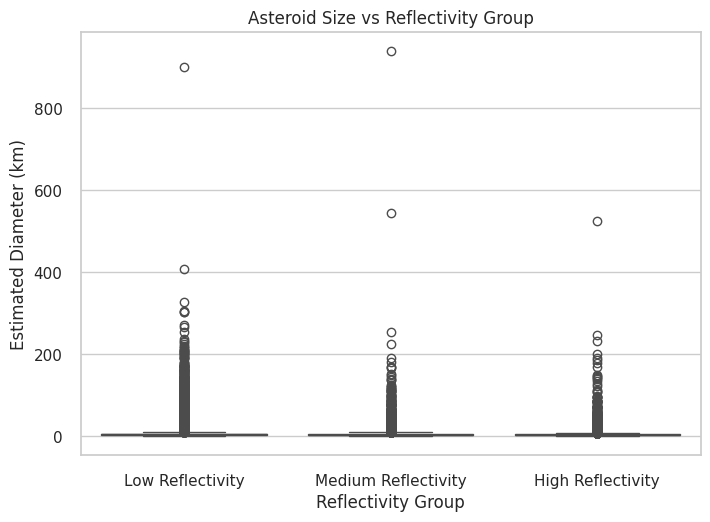

One-Way ANOVA:
F-statistic = 767.230, p-value = 0.00000


/tmp/ipython-input-41-3909619770.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group['Asteroid_Size_km(Diameter)'].dropna() for name, group in df_anova.groupby('Reflectivity_Group')]


In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

print("""
H₀: μ₁ = μ₂ = μ₃ (Mean reflectivity is the same across small, medium, and large asteroid groups)
H₁: At least one mean is different
""")
# Example DataFrame columns:
# df_classification['Reflectivity'] (continuous)
# df_classification['Estimated_Diameter_km'] (continuous)
df_anova = df_regression[['Reflectivity', 'Asteroid_Size_km(Diameter)']]

#
# Step 1: Bin Reflectivity into categories
bins = [0.0, 0.08, 0.19, 1.0]  # Adjust based on your data range
labels = ['Low Reflectivity', 'Medium Reflectivity', 'High Reflectivity']
df_anova['Reflectivity_Group'] = pd.cut(df_anova['Reflectivity'], bins=bins, labels=labels)

# Optional: Check group counts
print(df_anova['Reflectivity_Group'].value_counts())

# Step 2: Boxplot visualization
sns.boxplot(data=df_anova, x='Reflectivity_Group', y='Asteroid_Size_km(Diameter)')
plt.title('Asteroid Size vs Reflectivity Group')
plt.ylabel('Estimated Diameter (km)')
plt.xlabel('Reflectivity Group')
plt.show()

# Step 3: One-Way ANOVA test
groups = [group['Asteroid_Size_km(Diameter)'].dropna() for name, group in df_anova.groupby('Reflectivity_Group')]
f_stat, p_value = f_oneway(*groups)

print(f"One-Way ANOVA:\nF-statistic = {f_stat:.3f}, p-value = {p_value:.5f}")


Conclusion: Reflectivity (albedo) has a statistically significant effect on asteroid size.

1-Way ANOVA: Asteroid Size vs Brightness


H₀: μ₁ = μ₂ = μ₃ (Mean brightness is the same across small, medium, and large asteroid groups)
H₁: At least one mean is different

Brightness_Group
Medium Brightness    70803
Low Brightness       34114
High Brightness      31291
Name: count, dtype: int64


/tmp/ipython-input-42-3583831040.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anova['Brightness_Group'] = pd.cut(df_anova['Brightness'], bins=bins, labels=labels)


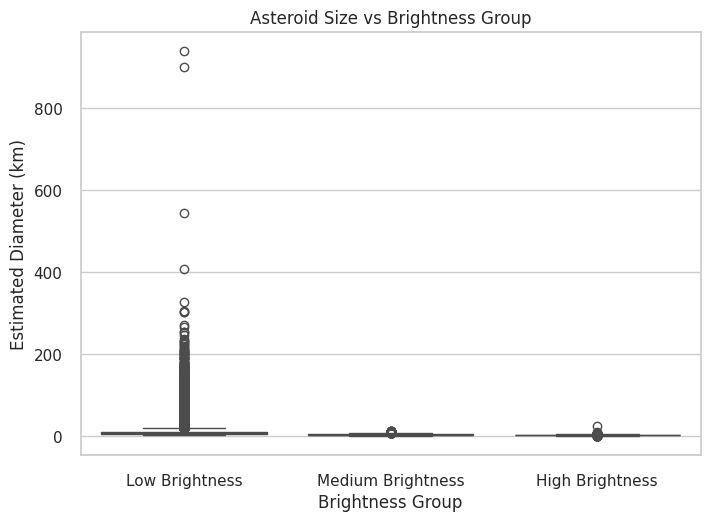

One-Way ANOVA:
F-statistic = 9415.048, p-value = 0.00000


/tmp/ipython-input-42-3583831040.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group['Asteroid_Size_km(Diameter)'].dropna() for name, group in df_anova.groupby('Brightness_Group')]


In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

print("""
H₀: μ₁ = μ₂ = μ₃ (Mean brightness is the same across small, medium, and large asteroid groups)
H₁: At least one mean is different
""")
# Example DataFrame columns:
# df_classification['Reflectivity'] (continuous)
# df_classification['Estimated_Diameter_km'] (continuous)
df_anova = df_regression[['Brightness', 'Asteroid_Size_km(Diameter)']]

#
# Step 1: Bin Reflectivity into categories
bins = [3.0, 14.4, 16.0, 29.9]  # Adjust based on your data range
labels = ['Low Brightness', 'Medium Brightness', 'High Brightness']
df_anova['Brightness_Group'] = pd.cut(df_anova['Brightness'], bins=bins, labels=labels)

# Optional: Check group counts
print(df_anova['Brightness_Group'].value_counts())

# Step 2: Boxplot visualization
sns.boxplot(data=df_anova, x='Brightness_Group', y='Asteroid_Size_km(Diameter)')
plt.title('Asteroid Size vs Brightness Group')
plt.ylabel('Estimated Diameter (km)')
plt.xlabel('Brightness Group')
plt.show()

# Step 3: One-Way ANOVA test
groups = [group['Asteroid_Size_km(Diameter)'].dropna() for name, group in df_anova.groupby('Brightness_Group')]
f_stat, p_value = f_oneway(*groups)

print(f"One-Way ANOVA:\nF-statistic = {f_stat:.3f}, p-value = {p_value:.5f}")


In [43]:
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.formula.api import ols
df_2way = df_regression[['Asteroid_Class', 'Potentially_Hazardous', 'Asteroid_Size_km(Diameter)']]
df_2way['Potentially_Hazardous'] = df_2way['Potentially_Hazardous'].map({'Y': 1, 'N': 0})
# Make sure Potentially_Hazardous is numeric (0/1)
df_2way['Potentially_Hazardous'] = df_2way['Potentially_Hazardous'].astype(int)
df_2way['Asteroid_Size_km'] = df_2way["Asteroid_Size_km(Diameter)"]
# Two-Way ANOVA model
model = ols('Asteroid_Size_km ~ C(Asteroid_Class) + C(Potentially_Hazardous) + C(Asteroid_Class):C(Potentially_Hazardous)',
            data=df_2way).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                                                  sum_sq        df          F  \
C(Asteroid_Class)                           3.358573e+04      10.0  41.011434   
C(Potentially_Hazardous)                             NaN       1.0        NaN   
C(Asteroid_Class):C(Potentially_Hazardous)  3.553708e+00      10.0   0.004339   
Residual                                    1.115349e+07  136195.0        NaN   

                                                  PR(>F)  
C(Asteroid_Class)                           1.564306e-18  
C(Potentially_Hazardous)                             NaN  
C(Asteroid_Class):C(Potentially_Hazardous)  9.956700e-01  
Residual                                             NaN  


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 2
  warnings.warn('covariance of constraints does not have full '


# Classification Model

In [44]:
df_classification.keys()

Index(['Near_Earth_Object', 'Potentially_Hazardous', 'Brightness',
       'Orbit_Shape', 'Orbit_Distance_AU', 'Closest_Sun_Distance_AU',
       'Orbit_Tilt_Degrees', 'Orbit_Angle_1_Degrees', 'Orbit_Angle_2_Degrees',
       'Orbit_Angle_3_Degrees', 'Farthest_Sun_Distance_AU',
       'Orbit_Speed_Degrees_Per_Day', 'Orbit_Period_Days',
       'Orbit_Period_Years', 'Earth_Closest_Distance_AU',
       'Earth_Closest_Distance_Lunar', 'Asteroid_Class'],
      dtype='object')


Logistic Regression Results
Accuracy: 0.9987908101571947


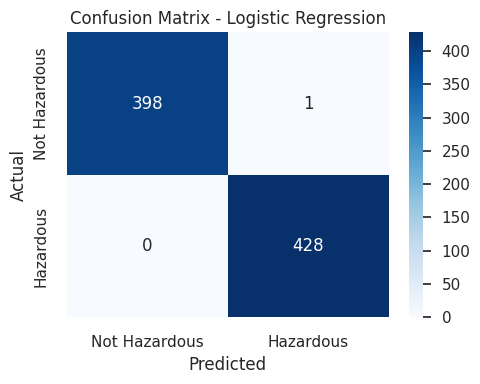


Classification Report:
               precision    recall  f1-score   support

           N       1.00      1.00      1.00       399
           Y       1.00      1.00      1.00       428

    accuracy                           1.00       827
   macro avg       1.00      1.00      1.00       827
weighted avg       1.00      1.00      1.00       827

Logistic Regression Coefficients:
Near_Earth_Object: 2.3924
Brightness: 0.7213
Orbit_Shape: -1.2942
Orbit_Distance_AU: -0.4981
Closest_Sun_Distance_AU: -0.0006
Orbit_Tilt_Degrees: -0.0063
Orbit_Angle_1_Degrees: -0.0051
Orbit_Angle_2_Degrees: 0.0000
Orbit_Angle_3_Degrees: 0.0001
Farthest_Sun_Distance_AU: 0.0000
Orbit_Speed_Degrees_Per_Day: -1.5004
Orbit_Period_Days: 0.9552
Orbit_Period_Years: -0.7850
Earth_Closest_Distance_AU: -0.1971
Earth_Closest_Distance_Lunar: -0.0003
Asteroid_Class: -0.0007


In [46]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

TARGET_class = 'Potentially_Hazardous'

# Balance the classes
class_Y = df_classification[df_classification[TARGET_class] == 'Y']
class_N = df_classification[df_classification[TARGET_class] == 'N'].sample(n=len(class_Y), random_state=42)
class_df = pd.concat([class_Y, class_N])

# Define categorical columns from the balanced dataframe
categorical_cols_c = class_df.select_dtypes(include=['object', 'bool']).drop(columns=[TARGET_class]).columns.tolist()

# Drop the target column
X_clf = class_df.drop(columns=[TARGET_class])
y_clf = class_df[TARGET_class]


# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols_c)
    ],
    remainder='passthrough'  # Keep numerical columns as-is
)

# Create pipeline with preprocessing + logistic regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)

# Evaluate
y_pred_clf = pipeline.predict(X_test)
print("\nLogistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_clf))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Get confusion matrix
cm = confusion_matrix(y_test, y_pred_clf)
# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hazardous', 'Hazardous'], yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred_clf))

clf_model = pipeline.named_steps['classifier']
feature_names = X_clf.columns

print("Logistic Regression Coefficients:")
for name, coef in zip(feature_names, clf_model.coef_[0]):
    print(f"{name}: {coef:.4f}")



# Regression Model

In [47]:
df_regression.keys()

Index(['Near_Earth_Object', 'Potentially_Hazardous', 'Brightness',
       'Asteroid_Size_km(Diameter)', 'Reflectivity', 'Orbit_Shape',
       'Orbit_Distance_AU', 'Closest_Sun_Distance_AU', 'Orbit_Tilt_Degrees',
       'Orbit_Angle_1_Degrees', 'Orbit_Angle_2_Degrees',
       'Orbit_Angle_3_Degrees', 'Farthest_Sun_Distance_AU',
       'Orbit_Speed_Degrees_Per_Day', 'Orbit_Period_Days',
       'Orbit_Period_Years', 'Earth_Closest_Distance_AU',
       'Earth_Closest_Distance_Lunar', 'Asteroid_Class'],
      dtype='object')

In [48]:
df_regression.describe()

Brightness  Asteroid_Size_km(Diameter)   Reflectivity  \
count  136209.000000               136209.000000  136209.000000   
mean       15.132319                    5.506429       0.130205   
std         1.366564                    9.425164       0.109971   
min         3.000000                    0.002500       0.001000   
25%        14.400000                    2.780000       0.053000   
50%        15.200000                    3.972000       0.079000   
75%        16.000000                    5.765000       0.188000   
max        29.900000                  939.400000       1.000000   

         Orbit_Shape  Orbit_Distance_AU  Closest_Sun_Distance_AU  \
count  136209.000000      136209.000000            136209.000000   
mean        0.145660           2.819158                 2.406130   
std         0.077464           1.495980                 0.516931   
min         0.000060           0.626210                 0.081820   
25%         0.089878           2.542856                 2.072478   
50%         0.138919           2.754950                 2.368605   
75%         0.191174           3.095029                 2.688275   
max         0.983789         376.133297                40.318477   

       Orbit_Tilt_Degrees  Orbit_Angle_1_Degrees  Orbit_Angle_2_Degrees  \
count       136209.000000          136209.000000          136209.000000   
mean            10.295360             169.729893             181.808169   
std              6.812632             102.715175             103.516287   
min              0.022056               0.000418               0.000130   
25%              5.088142              82.276476              91.903488   
50%              9.335690             160.301343             183.509496   
75%             13.670331             255.961202             271.642281   
max            170.334595             359.999793             359.998075   

       Orbit_Angle_3_Degrees  Farthest_Sun_Distance_AU  \
count          136209.000000             136209.000000   
mean              184.529202                  3.232187   
std               105.632553                  2.839820   
min                 0.005112                  0.999954   
25%                91.647097                  2.871056   
50%               188.275290                  3.173515   
75%               277.821001                  3.472570   
max               391.682098                746.169105   

       Orbit_Speed_Degrees_Per_Day  Orbit_Period_Days  Orbit_Period_Years  \
count                136209.000000       1.362090e+05       136209.000000   
mean                      0.219086       1.787231e+03            4.893173   
std                       0.056912       8.965840e+03           24.547132   
min                       0.000135       1.809999e+02            0.495551   
25%                       0.181012       1.481089e+03            4.055000   
50%                       0.215543       1.670202e+03            4.572764   
75%                       0.243064       1.988820e+03            5.445092   
max                       1.988951       2.664472e+06         7294.925719   

       Earth_Closest_Distance_AU  Earth_Closest_Distance_Lunar  
count              136209.000000                 136209.000000  
mean                    1.423858                    554.122719  
std                     0.513029                    199.655301  
min                     0.000027                      0.010335  
25%                     1.086220                    422.724237  
50%                     1.389580                    540.782849  
75%                     1.702400                    662.523008  
max                    39.360300                  15317.847951

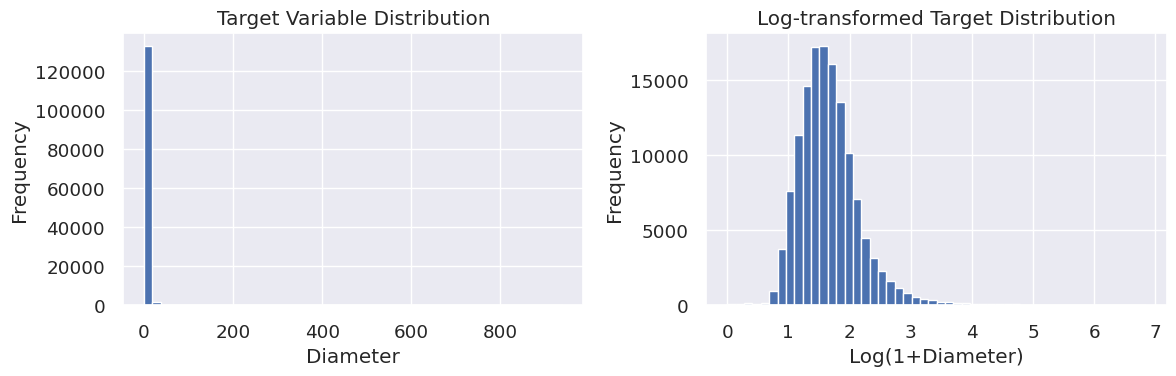


3.1.1 TRADITIONAL LINEAR REGRESSION
--------------------------------------------------
Linear Regression Results (on log scale):
R² Score: 0.890359960473653
RMSE: 0.1739746597052796

Linear Regression Results (original scale):
R² Score: 0.7153304912055688
RMSE: 5.358868083410236

3.1.2 VARIABLE SELECTION METHODS
--------------------------------------------------
1. Recursive Feature Elimination with Cross-Validation (RFECV)
Optimal number of features: 23
Selected features: ['cat__Near_Earth_Object_Y', 'cat__Potentially_Hazardous_Y', 'cat__Asteroid_Class_APO', 'cat__Asteroid_Class_ATE', 'cat__Asteroid_Class_CEN', 'cat__Asteroid_Class_IMB', 'cat__Asteroid_Class_MBA', 'cat__Asteroid_Class_MCA', 'cat__Asteroid_Class_OMB', 'cat__Asteroid_Class_TNO', 'remainder__Brightness', 'remainder__Reflectivity', 'remainder__Orbit_Shape', 'remainder__Orbit_Distance_AU', 'remainder__Closest_Sun_Distance_AU', 'remainder__Orbit_Tilt_Degrees', 'remainder__Orbit_Angle_3_Degrees', 'remainder__Farthest_Sun_Di

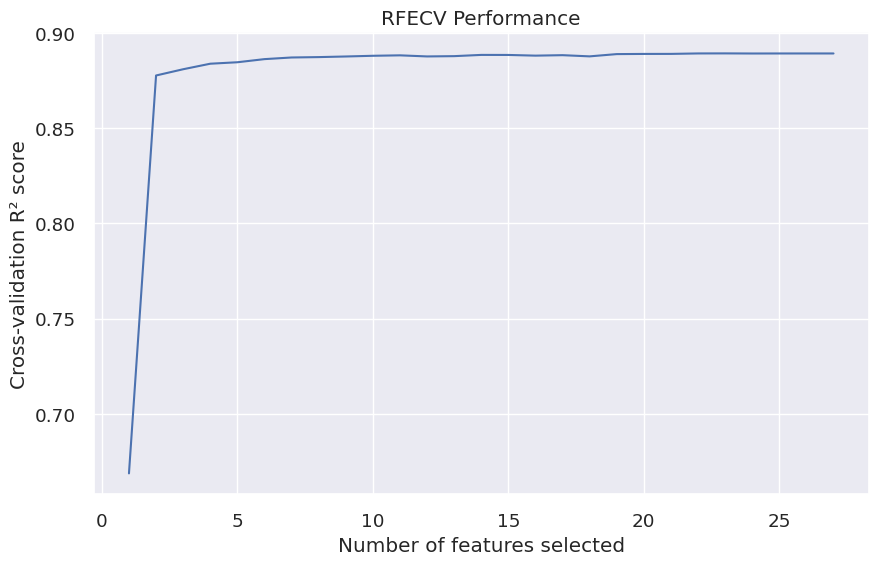


2. SelectKBest with Mutual Information
Selected features (MI): ['remainder__Brightness', 'remainder__Reflectivity', 'remainder__Orbit_Distance_AU', 'remainder__Closest_Sun_Distance_AU', 'remainder__Orbit_Speed_Degrees_Per_Day', 'remainder__Orbit_Period_Days', 'remainder__Earth_Closest_Distance_AU', 'remainder__Earth_Closest_Distance_Lunar']

3. Forward Stepwise Selection
Selected features (Stepwise): ['cat__Near_Earth_Object_Y', 'cat__Asteroid_Class_ATE', 'remainder__Brightness', 'remainder__Reflectivity', 'remainder__Orbit_Shape', 'remainder__Orbit_Tilt_Degrees', 'remainder__Orbit_Speed_Degrees_Per_Day', 'remainder__Earth_Closest_Distance_AU']

Performing PCA analysis...
Number of components explaining 95% variance: 17
Cumulative variance explained: 0.9594

3.1.3 FINAL MODEL WITH PCA
--------------------------------------------------
PCA Model Results:
R² Score (log scale): 0.6499902127414483
R² Score (original scale): 0.27808200226241164
RMSE (original scale): 8.533879867174933

RFE

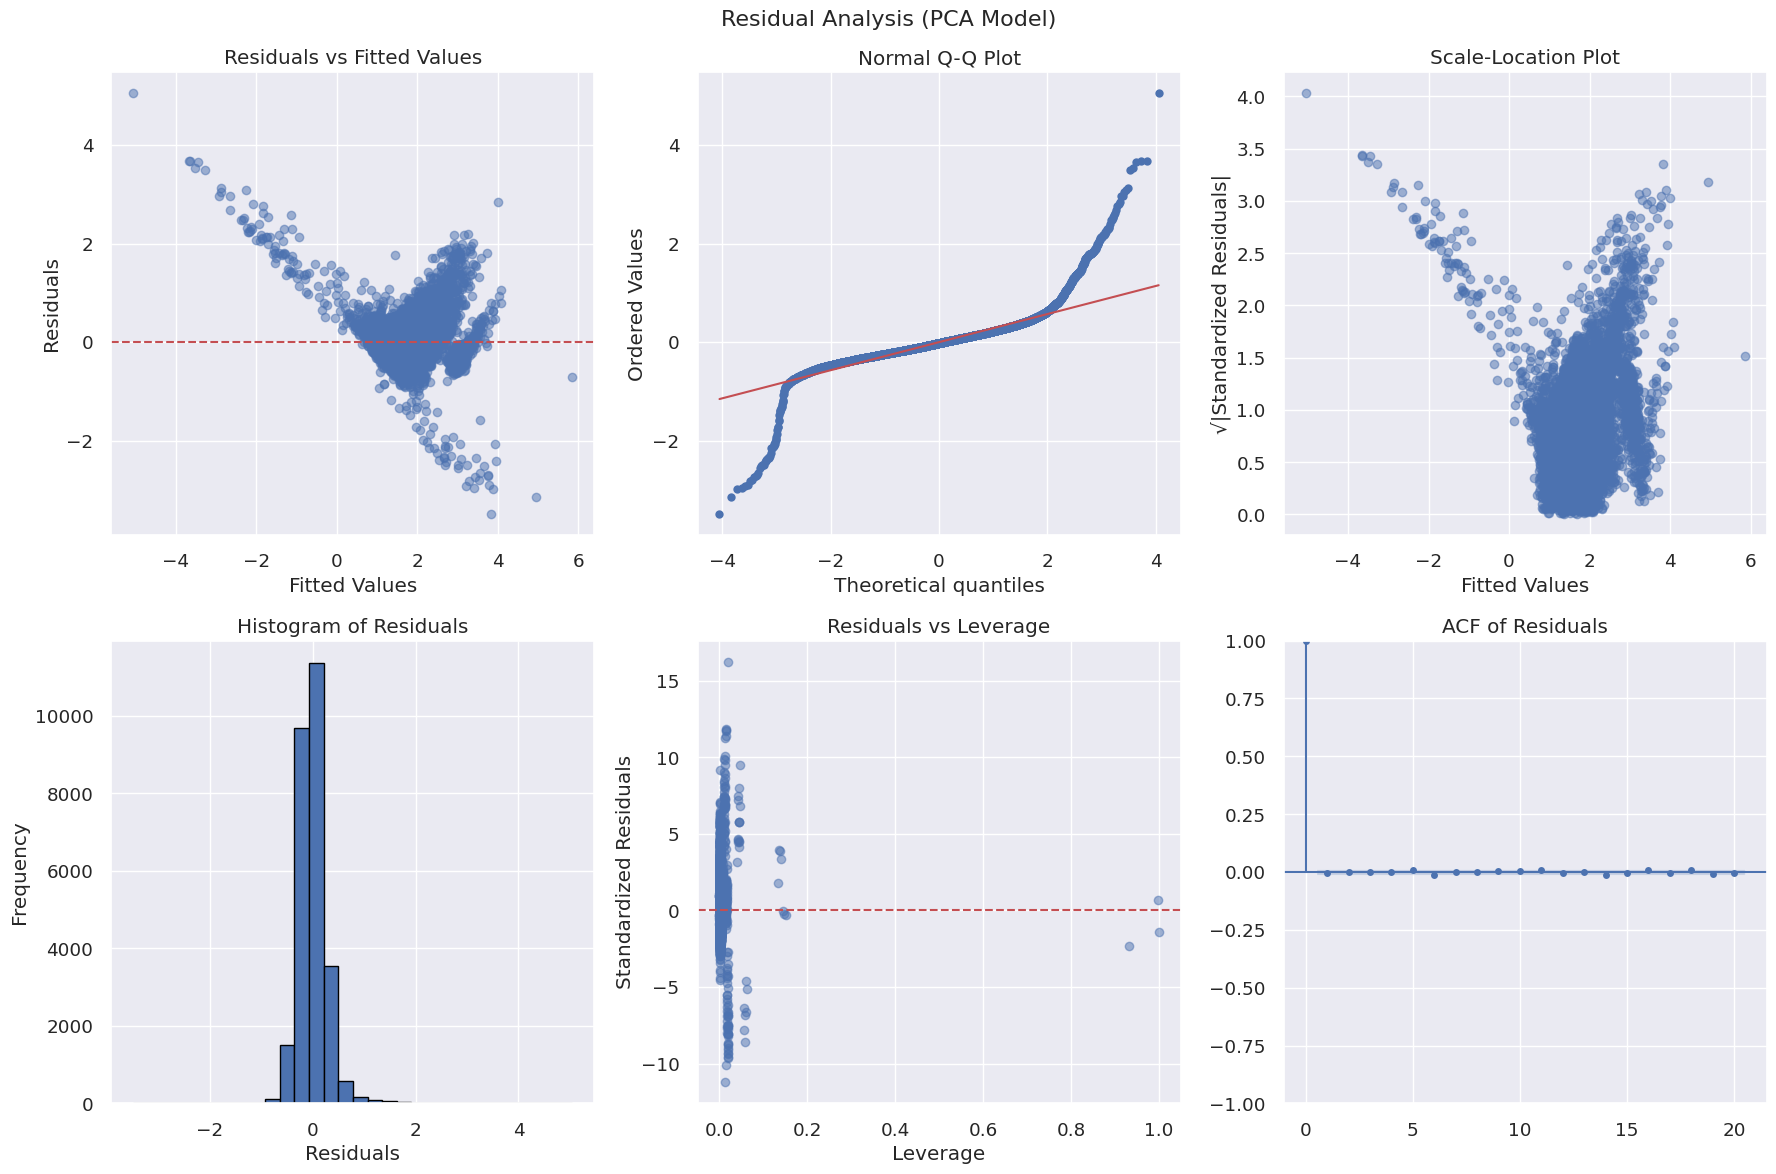


FORMAL TESTS:
------------------------------
1. Normality Tests:
   Shapiro-Wilk test skipped (dataset too large)
   D'Agostino's K² test p-value: 0.0000

2. Homoscedasticity Test:
   Breusch-Pagan test p-value: 0.0000

3. Independence Test:
   Durbin-Watson statistic: 2.0070
   (Values close to 2 indicate no autocorrelation)

4. PCA Component Analysis:
   Number of principal components: 17
   Total variance explained: 0.9594
   (By construction, PCA components have VIF = 1)

3.1.5 TRANSFORMATIONS AND REMEDIAL MEASURES
--------------------------------------------------
Non-normality detected in residuals.
Heteroscedasticity detected.

Applying transformations:
1. Box-Cox transformation with lambda: -0.1324

Results after transformations:
R² Score: 0.399532698334372
RMSE: 0.7212225426426362

SUMMARY OF LINEAR REGRESSION ANALYSIS
1. Initial features: 27
2. Selected features (RFECV): 23
3. Selected features names: ['cat__Near_Earth_Object_Y', 'cat__Potentially_Hazardous_Y', 'cat__Asteroi

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV, SelectKBest, f_regression, mutual_info_regression, SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import scipy.stats as stats
from scipy.stats import normaltest, kstest, shapiro
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set the style for plots
plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.2)

TARGET_reg = 'Asteroid_Size_km(Diameter)'

# Define categorical columns from the balanced dataframe
categorical_cols_r = df_regression.select_dtypes(include=['object', 'bool']).drop(columns=[TARGET_reg], errors='ignore').columns.tolist()

# Drop the target column
X_reg = df_regression.drop(columns=[TARGET_reg])
y_reg = df_regression[TARGET_reg]

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols_r)
    ],
    remainder='passthrough'  # Keep numerical columns as-is
)

# Check for data distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(y_reg, bins=50)
plt.title('Target Variable Distribution')
plt.xlabel('Diameter')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(y_reg), bins=50)
plt.title('Log-transformed Target Distribution')
plt.xlabel('Log(1+Diameter)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('target_distribution.png')
plt.show()

# Apply log transformation to target
y_reg_transformed = np.log1p(y_reg)

# 3.1.1 Traditional Linear Regression
print("\n3.1.1 TRADITIONAL LINEAR REGRESSION")
print("-" * 50)

# Train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg_transformed, test_size=0.2, random_state=42
)

# Pipeline for preprocessing and model
reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Train the model
reg_pipeline.fit(X_train_reg, y_train_reg)

# Predict and evaluate
y_pred_reg = reg_pipeline.predict(X_test_reg)
y_pred_original = np.expm1(y_pred_reg)
y_test_original = np.expm1(y_test_reg)

print("Linear Regression Results (on log scale):")
print("R² Score:", r2_score(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))

print("\nLinear Regression Results (original scale):")
print("R² Score:", r2_score(y_test_original, y_pred_original))
print("RMSE:", np.sqrt(mean_squared_error(y_test_original, y_pred_original)))

# 3.1.2 Variable Selection Methods
print("\n3.1.2 VARIABLE SELECTION METHODS")
print("-" * 50)

# Prepare data for variable selection - Apply preprocessing first
X_train_prepared = preprocessor.fit_transform(X_train_reg)
X_train_scaled = StandardScaler().fit_transform(X_train_prepared)
X_test_prepared = preprocessor.transform(X_test_reg)
X_test_scaled = StandardScaler().fit_transform(X_test_prepared)

# Method 1: Recursive Feature Elimination with Cross-Validation
print("1. Recursive Feature Elimination with Cross-Validation (RFECV)")
rfecv = RFECV(estimator=LinearRegression(), cv=5, scoring='r2')
rfecv.fit(X_train_scaled, y_train_reg)

print(f"Optimal number of features: {rfecv.n_features_}")
# Get feature names from preprocessor if possible, otherwise use indices
try:
    feature_names = preprocessor.get_feature_names_out()
    print(f"Selected features: {feature_names[rfecv.support_].tolist()}")
except:
    print(f"Selected feature indices: {np.where(rfecv.support_)[0].tolist()}")

# Plot RFECV results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel('Number of features selected')
plt.ylabel('Cross-validation R² score')
plt.title('RFECV Performance')
plt.grid(True)
plt.savefig('rfecv_performance.png')
plt.show()

# Method 2: SelectKBest with mutual information
print("\n2. SelectKBest with Mutual Information")
selector_mi = SelectKBest(mutual_info_regression, k=8)
selector_mi.fit(X_train_scaled, y_train_reg)
try:
    feature_names = preprocessor.get_feature_names_out()
    selected_features_mi = feature_names[selector_mi.get_support()].tolist()
    print(f"Selected features (MI): {selected_features_mi}")
except:
    print(f"Selected feature indices (MI): {np.where(selector_mi.get_support())[0].tolist()}")

# Method 3: Forward Stepwise Selection using sklearn
print("\n3. Forward Stepwise Selection")
# Use SequentialFeatureSelector for forward stepwise selection
sfs = SequentialFeatureSelector(
    LinearRegression(),
    n_features_to_select=8,
    direction='forward',
    cv=5,
    scoring='r2'
)
sfs.fit(X_train_scaled, y_train_reg)
try:
    feature_names = preprocessor.get_feature_names_out()
    stepwise_features = feature_names[sfs.support_].tolist()
    print(f"Selected features (Stepwise): {stepwise_features}")
except:
    print(f"Selected feature indices (Stepwise): {np.where(sfs.support_)[0].tolist()}")

# Perform PCA analysis
print("\nPerforming PCA analysis...")
pca = PCA()
pca.fit(X_train_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Find number of components explaining 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# Create PCA results dictionary
pca_results = {
    'n_components_95': n_components_95,
    'cumulative_variance': cumulative_variance,
    'explained_variance_ratio': explained_variance_ratio
}

print(f"Number of components explaining 95% variance: {n_components_95}")
print(f"Cumulative variance explained: {cumulative_variance[n_components_95-1]:.4f}")

# Train final model with selected features
print("\n3.1.3 FINAL MODEL WITH PCA")
print("-" * 50)

# Create the final PCA pipeline with optimal number of components
final_pca_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=pca_results['n_components_95'])),
    ('model', LinearRegression())
])

# Train the PCA model
final_pca_pipeline.fit(X_train_reg, y_train_reg)

# Train RFECV model for comparison using feature indices
# Create a mask of selected features after preprocessing
selector_mask = np.zeros(X_train_scaled.shape[1], dtype=bool)
selector_mask[np.where(rfecv.support_)[0]] = True

# Create pipeline for RFECV model
rfecv_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(mutual_info_regression, k=rfecv.n_features_)),  # Using SelectKBest as substitute
    ('model', LinearRegression())
])
rfecv_pipeline.fit(X_train_reg, y_train_reg)

# Predict and evaluate both models
print("PCA Model Results:")
y_pred_pca = final_pca_pipeline.predict(X_test_reg)
y_pred_pca_original = np.expm1(y_pred_pca)
print("R² Score (log scale):", r2_score(y_test_reg, y_pred_pca))
print("R² Score (original scale):", r2_score(y_test_original, y_pred_pca_original))
print("RMSE (original scale):", np.sqrt(mean_squared_error(y_test_original, y_pred_pca_original)))

print("\nRFECV Model Results:")
y_pred_rfecv = rfecv_pipeline.predict(X_test_reg)
y_pred_rfecv_original = np.expm1(y_pred_rfecv)
print("R² Score (log scale):", r2_score(y_test_reg, y_pred_rfecv))
print("R² Score (original scale):", r2_score(y_test_original, y_pred_rfecv_original))
print("RMSE (original scale):", np.sqrt(mean_squared_error(y_test_original, y_pred_rfecv_original)))

# Use PCA model for residual analysis
best_model = final_pca_pipeline
y_pred_final = y_pred_pca

# 3.1.4 Residual Analysis
print("\n3.1.4 RESIDUAL ANALYSIS")
print("-" * 50)

# Calculate residuals
residuals = y_test_reg - y_pred_final
standardized_residuals = residuals / np.std(residuals)

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Residual Analysis (PCA Model)', fontsize=16)

# 1. Residuals vs Fitted Values (Linearity and Homoscedasticity)
axes[0, 0].scatter(y_pred_final, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values')

# 2. Normal Q-Q Plot (Normality)
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot')

# 3. Scale-Location Plot (Homoscedasticity)
axes[0, 2].scatter(y_pred_final, np.sqrt(np.abs(standardized_residuals)), alpha=0.5)
axes[0, 2].set_xlabel('Fitted Values')
axes[0, 2].set_ylabel('√|Standardized Residuals|')
axes[0, 2].set_title('Scale-Location Plot')

# 4. Histogram of Residuals (Normality)
axes[1, 0].hist(residuals, bins=30, edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Histogram of Residuals')

# 5. Residuals vs Leverage (Outliers and Influence)
# Calculate leverage for PCA-transformed data
X_test_transformed = final_pca_pipeline.named_steps['pca'].transform(
    final_pca_pipeline.named_steps['scaler'].transform(
        final_pca_pipeline.named_steps['preprocessor'].transform(X_test_reg)
    )
)
# Add intercept column
X_with_intercept = np.column_stack([np.ones(X_test_transformed.shape[0]), X_test_transformed])
# Calculate hat matrix diagonal (leverage values)
hat_matrix = X_with_intercept @ np.linalg.inv(X_with_intercept.T @ X_with_intercept + 1e-8 * np.eye(X_with_intercept.shape[1])) @ X_with_intercept.T
leverage = np.diag(hat_matrix)

axes[1, 1].scatter(leverage, standardized_residuals, alpha=0.5)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Leverage')
axes[1, 1].set_ylabel('Standardized Residuals')
axes[1, 1].set_title('Residuals vs Leverage')

# 6. ACF of Residuals (Independence)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, ax=axes[1, 2], lags=20)
axes[1, 2].set_title('ACF of Residuals')

plt.tight_layout()
plt.savefig('residual_analysis_pca.png', dpi=300, bbox_inches='tight')
plt.show()

# Formal tests for assumptions
print("\nFORMAL TESTS:")
print("-" * 30)

# 1. Normality of residuals
print("1. Normality Tests:")
if len(residuals) <= 5000:  # Shapiro-Wilk has a limit
    _, p_shapiro = shapiro(residuals)
    print(f"   Shapiro-Wilk test p-value: {p_shapiro:.4f}")
else:
    print("   Shapiro-Wilk test skipped (dataset too large)")
    p_shapiro = np.nan

_, p_normaltest = normaltest(residuals)
print(f"   D'Agostino's K² test p-value: {p_normaltest:.4f}")

# 2. Homoscedasticity (Breusch-Pagan test)
print("\n2. Homoscedasticity Test:")
import statsmodels.stats.api as sms
# Get transformed features for Breusch-Pagan test
X_test_transformed = final_pca_pipeline.named_steps['pca'].transform(
    final_pca_pipeline.named_steps['scaler'].transform(
        final_pca_pipeline.named_steps['preprocessor'].transform(X_test_reg)
    )
)
# Add constant for Breusch-Pagan test
X_test_with_constant = np.column_stack([np.ones(X_test_transformed.shape[0]), X_test_transformed])
_, p_bp = sms.het_breuschpagan(residuals, X_test_with_constant)[:2]
print(f"   Breusch-Pagan test p-value: {p_bp:.4f}")

# 3. Independence (Durbin-Watson test)
print("\n3. Independence Test:")
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"   Durbin-Watson statistic: {dw_stat:.4f}")
print("   (Values close to 2 indicate no autocorrelation)")

# 4. Multicollinearity (VIF) - Now with PCA
print("\n4. PCA Component Analysis:")
print(f"   Number of principal components: {n_components_95}")
print(f"   Total variance explained: {cumulative_variance[n_components_95-1]:.4f}")
print("   (By construction, PCA components have VIF = 1)")

# 3.1.5 Transformations and Remedial Measures
print("\n3.1.5 TRANSFORMATIONS AND REMEDIAL MEASURES")
print("-" * 50)

# Check if transformations are needed based on tests
need_transform = False
transformations_applied = []

# Based on residual analysis results
if (not np.isnan(p_shapiro) and p_shapiro < 0.05) or p_normaltest < 0.05:
    print("Non-normality detected in residuals.")
    need_transform = True

if p_bp < 0.05:
    print("Heteroscedasticity detected.")
    need_transform = True

if dw_stat < 1.5 or dw_stat > 2.5:
    print("Potential autocorrelation detected.")

if need_transform:
    print("\nApplying transformations:")

    # 1. Try Box-Cox transformation on target
    from scipy.stats import boxcox

    # Ensure all values are positive for Box-Cox
    y_reg_positive = y_reg + abs(y_reg.min()) + 1 if y_reg.min() <= 0 else y_reg
    y_boxcox, lambda_boxcox = boxcox(y_reg_positive)
    print(f"1. Box-Cox transformation with lambda: {lambda_boxcox:.4f}")

    # 2. Apply power transformation to features
    transformer = PowerTransformer(method='yeo-johnson')

    # Train model with transformed data
    transformed_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('power_transform', transformer),
        ('pca', PCA(n_components=pca_results['n_components_95'])),
        ('model', LinearRegression())
    ])

    # Split with Box-Cox transformed target
    y_train_boxcox = boxcox(y_train_reg + abs(y_train_reg.min()) + 1 if y_train_reg.min() <= 0 else y_train_reg)[0]
    y_test_boxcox = boxcox(y_test_reg + abs(y_test_reg.min()) + 1 if y_test_reg.min() <= 0 else y_test_reg)[0]

    # Train with transformed target
    transformed_pipeline.fit(X_train_reg, y_train_boxcox)
    y_pred_transformed = transformed_pipeline.predict(X_test_reg)

    # Back-transform predictions - handle the transformation carefully
    if lambda_boxcox != 0:
        y_pred_backtransformed = np.power(y_pred_transformed * lambda_boxcox + 1, 1/lambda_boxcox) - abs(y_reg.min()) - 1
        y_test_backtransformed = np.power(y_test_boxcox * lambda_boxcox + 1, 1/lambda_boxcox) - abs(y_reg.min()) - 1
    else:
        y_pred_backtransformed = np.exp(y_pred_transformed) - abs(y_reg.min()) - 1
        y_test_backtransformed = np.exp(y_test_boxcox) - abs(y_reg.min()) - 1

    # Ensure non-negative predictions
    y_pred_backtransformed = np.maximum(y_pred_backtransformed, 0)
    y_test_backtransformed = np.maximum(y_test_backtransformed, 0)

    print("\nResults after transformations:")
    print("R² Score:", r2_score(y_test_backtransformed, y_pred_backtransformed))
    print("RMSE:", np.sqrt(mean_squared_error(y_test_backtransformed, y_pred_backtransformed)))

    # Re-check residuals
    residuals_transformed = y_test_boxcox - y_pred_transformed
    if len(residuals_transformed) <= 5000:  # Only run if manageable size
        _, p_shapiro_transformed = shapiro(residuals_transformed)
        print(f"\nShapiro-Wilk test p-value after transformation: {p_shapiro_transformed:.4f}")

else:
    print("No major violations detected. Current model appears adequate.")

# Summary
print("\n" + "="*50)
print("SUMMARY OF LINEAR REGRESSION ANALYSIS")
print("="*50)
print(f"1. Initial features: {X_train_scaled.shape[1]}")

# For RFECV selected features
try:
    feature_names = preprocessor.get_feature_names_out()
    selected_features = feature_names[rfecv.support_].tolist()
    print(f"2. Selected features (RFECV): {rfecv.n_features_}")
    print(f"3. Selected features names: {selected_features}")
except:
    print(f"2. Selected features (RFECV): {rfecv.n_features_}")
    print(f"3. Selected feature indices: {np.where(rfecv.support_)[0].tolist()}")

print(f"4. Final R² score (log scale): {r2_score(y_test_reg, y_pred_final):.4f}")
y_pred_final_original = np.expm1(y_pred_final)
print(f"5. Final RMSE (original scale): {np.sqrt(mean_squared_error(y_test_original, y_pred_final_original)):.4f}")
print("\nAssumption Test Results:")
print(f"- Normality (p-value): {p_shapiro:.4f}" if not np.isnan(p_shapiro) else "- Normality: Test skipped (dataset too large)")
print(f"- Homoscedasticity (p-value): {p_bp:.4f}")
print(f"- Independence (Durbin-Watson): {dw_stat:.4f}")
print(f"- Multicollinearity: Handled by PCA")

# Define final_pipeline for the prediction function
final_pipeline = final_pca_pipeline  # Using PCA pipeline as final model

# Create a prediction function using PCA model
def predict_diameter(features_dict):
    """
    Predict asteroid diameter using the final linear regression model.

    Parameters:
    features_dict (dict): Dictionary with feature names as keys and values as input

    Returns:
    float: Predicted diameter in km
    """
    # Create DataFrame from input
    input_df = pd.DataFrame([features_dict])

    # Make prediction (on log scale)
    y_pred_log = final_pipeline.predict(input_df)

    # Convert back to original scale
    y_pred_original = np.expm1(y_pred_log)

    return y_pred_original[0]

# # Example usage
# example_features = {
#     'H': 15.0,
#     'albedo': 0.1,
#     'e': 0.2,
#     'a': 2.5,
#     'q': 2.0,
#     'i': 5.0,
#     'om': 100.0,
#     'w': 200.0,
#     'ma': 45.0,
#     'ad': 3.0,
#     'n': 0.5,
#     'per': 1000.0,
#     'per_y': 2.7,
#     'moid': 0.1,
#     'moid_ld': 39.0
# }

# print(f"\nExample prediction:")
# print(f"Predicted diameter: {predict_diameter(example_features):.2f} km")

Initial data shape: (136209, 19)
Data shape after outlier removal: (128150, 19)


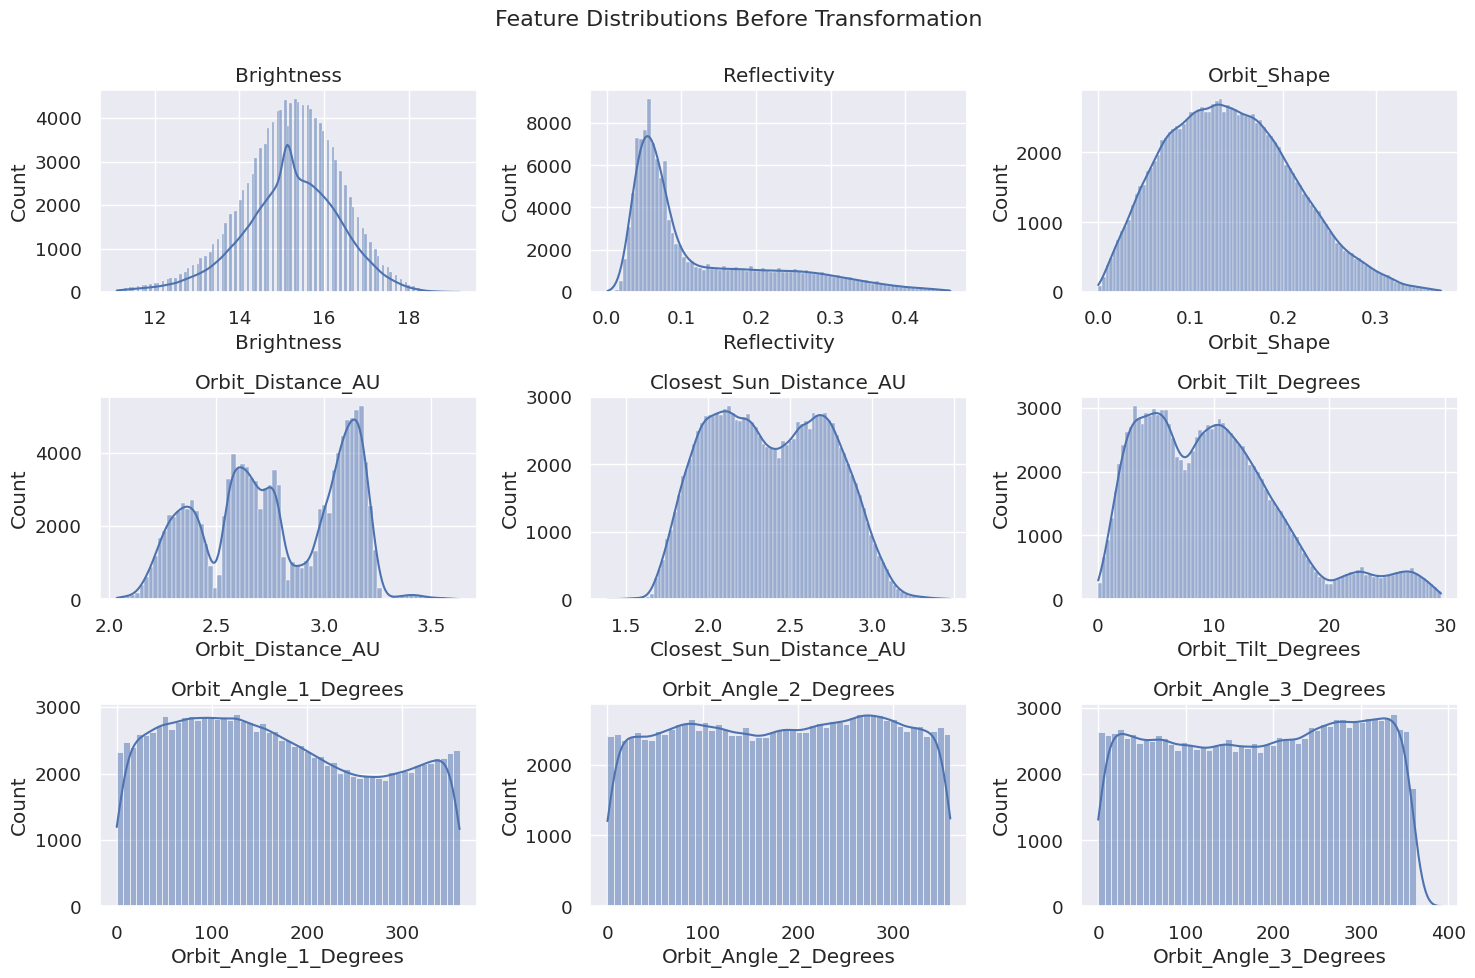

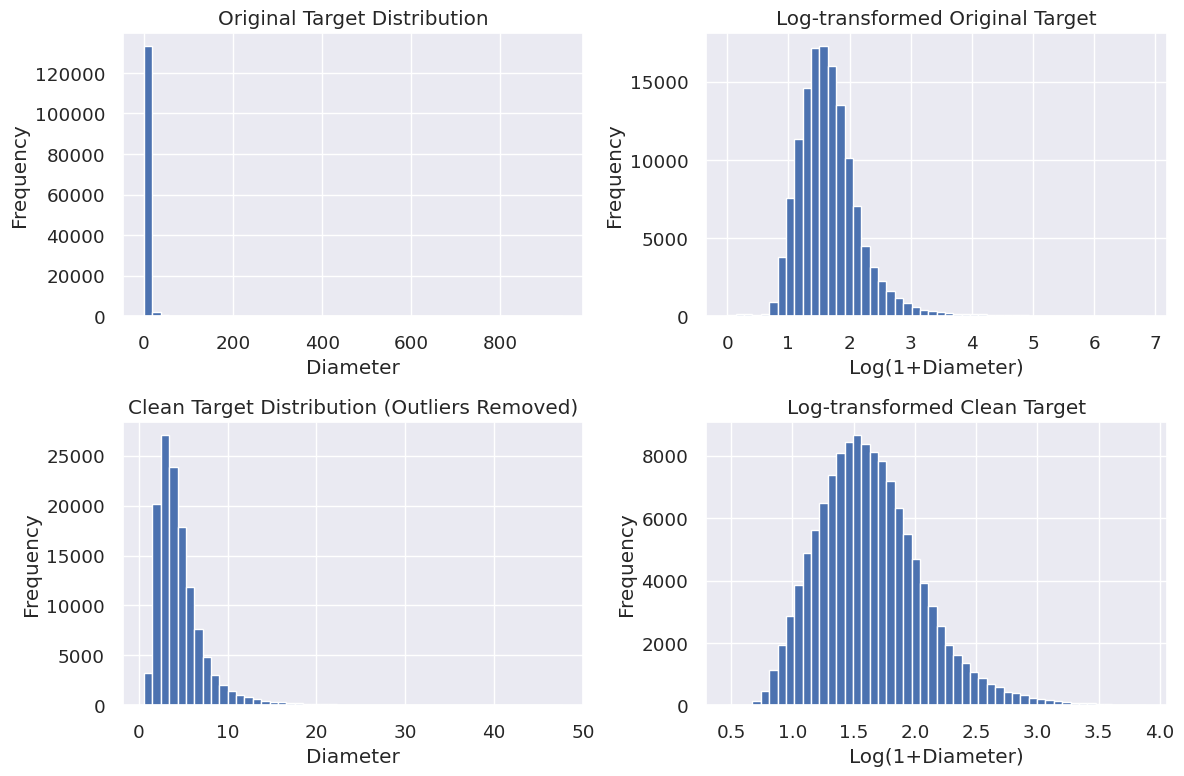


SECTION 1: BASELINE MODEL (WITHOUT OUTLIER REMOVAL OR BOX-COX)

BASELINE MODEL METRICS (NO OUTLIER REMOVAL, NO BOX-COX):
------------------------------------------------------------
R² Score (log scale): 0.8904
RMSE (log scale): 0.1740
R² Score (original scale): 0.7153
RMSE (original scale): 5.3589

SECTION 2: ENHANCED MODEL (WITH OUTLIER REMOVAL AND BOX-COX)

ENHANCED MODEL METRICS (WITH OUTLIER REMOVAL AND BOX-COX):
------------------------------------------------------------
R² Score (log scale): 0.8662
RMSE (log scale): 0.1587
R² Score (original scale): 0.8427
RMSE (original scale): 1.2831

COMPARISON SUMMARY
Baseline Model (log scale):
R² Score: 0.8904
RMSE: 0.1740

Enhanced Model (log scale):
R² Score: 0.8662
RMSE: 0.1587

R² Improvement: -2.72%
RMSE Improvement: 8.79%


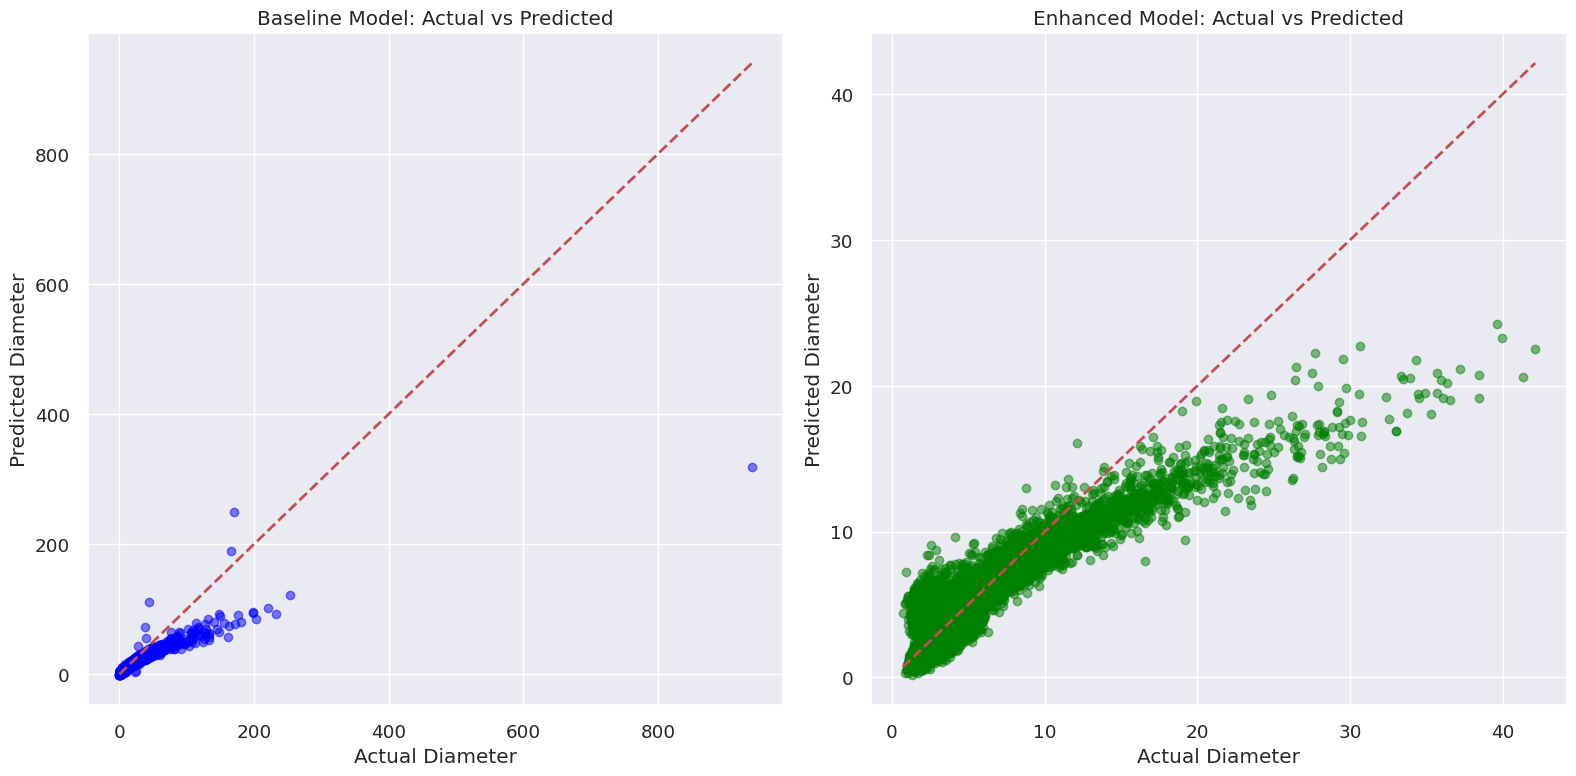

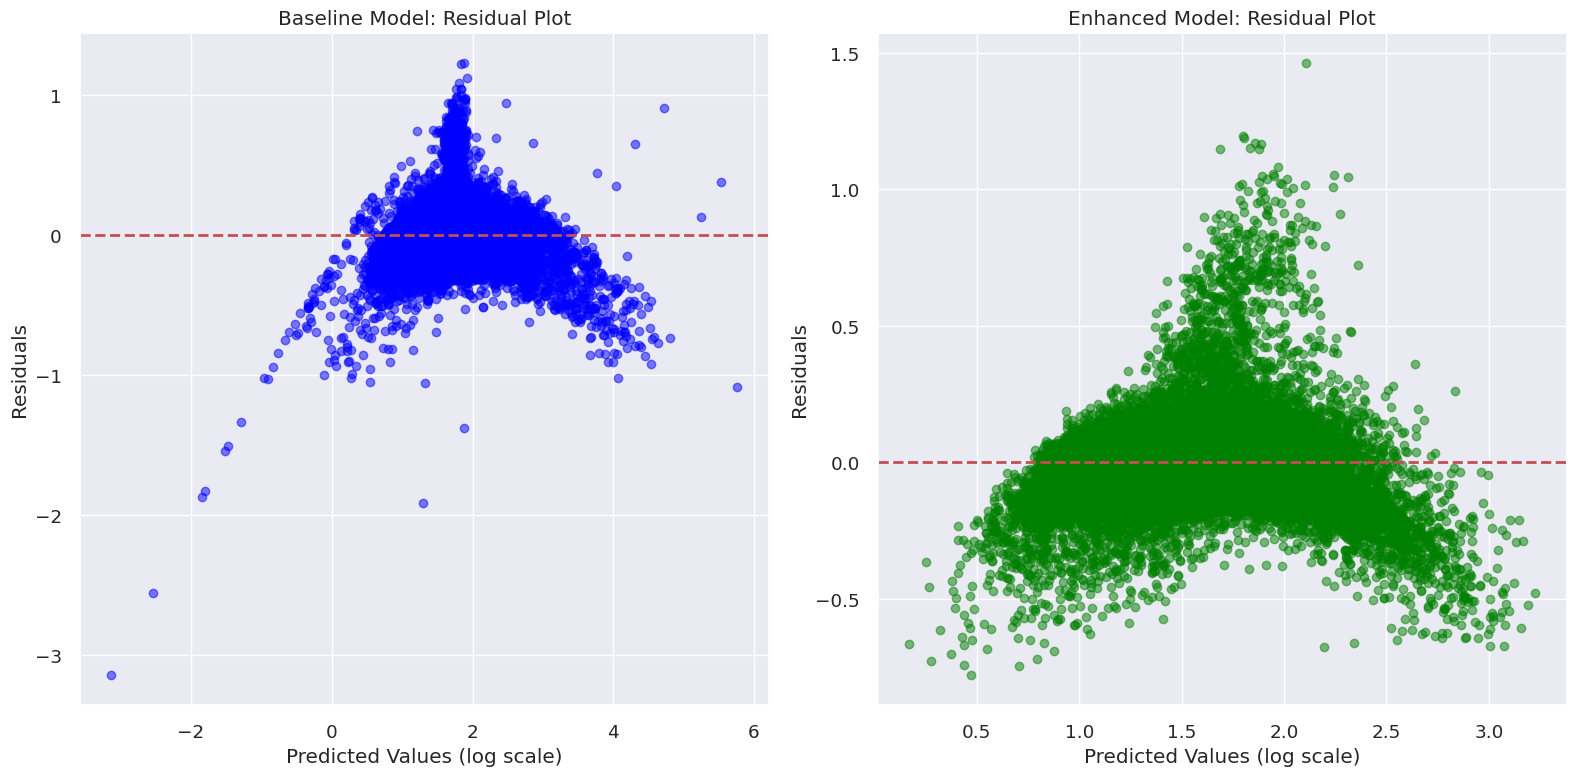

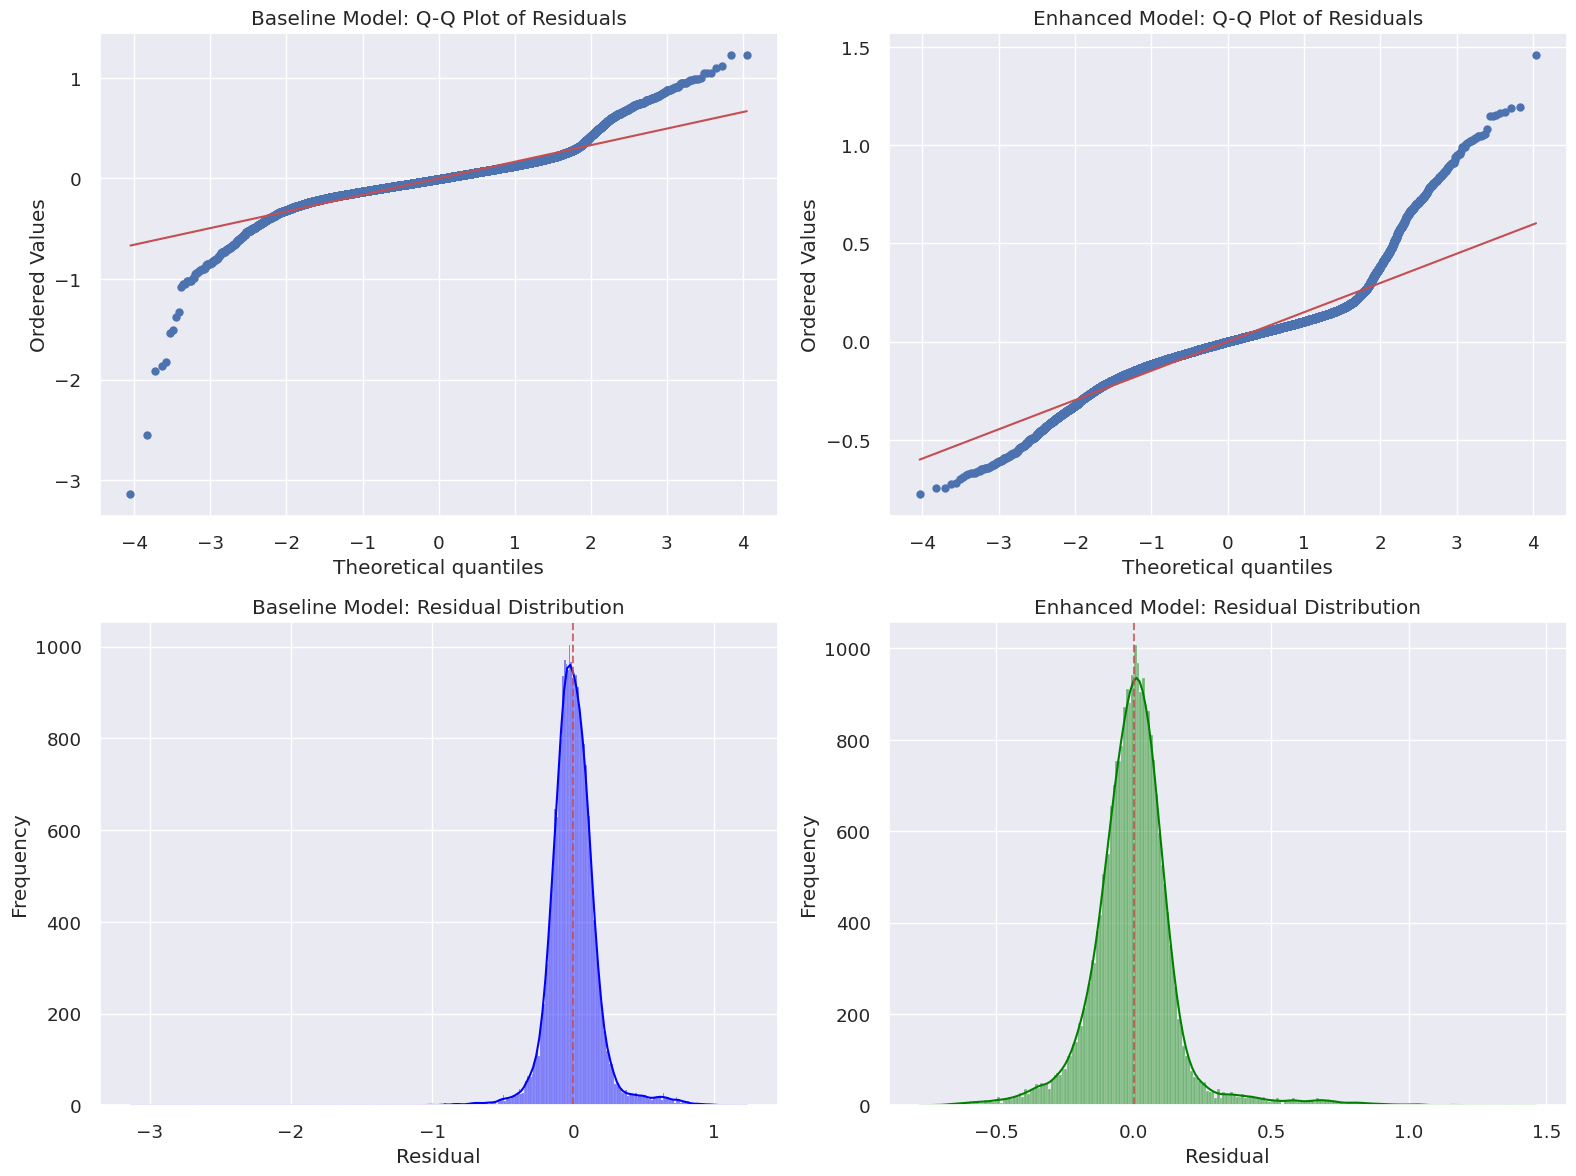


RESIDUAL NORMALITY TESTS

Baseline Model Residuals:
----------------------------------------
Shapiro-Wilk Test: W=0.8967, p-value=0.000000
Conclusion: Residuals are NOT normally distributed (reject H0)
D'Agostino's K² Test: K²=5430.4622, p-value=0.000000
Conclusion: Residuals are NOT normally distributed (reject H0)
Kolmogorov-Smirnov Test: D=0.0784, p-value=0.000000
Conclusion: Residuals are NOT normally distributed (reject H0)

Skewness: 0.0495
Kurtosis: 12.8693
Mean: 0.000313 (should be close to 0)
Standard Deviation: 0.173974

Enhanced Model Residuals:
----------------------------------------
Shapiro-Wilk Test: W=0.8833, p-value=0.000000
Conclusion: Residuals are NOT normally distributed (reject H0)
D'Agostino's K² Test: K²=7562.6214, p-value=0.000000
Conclusion: Residuals are NOT normally distributed (reject H0)
Kolmogorov-Smirnov Test: D=0.1013, p-value=0.000000
Conclusion: Residuals are NOT normally distributed (reject H0)

Skewness: 1.1430
Kurtosis: 7.8991
Mean: 0.000636 (shou

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV, SelectKBest, f_regression, mutual_info_regression, SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import scipy.stats as stats
from scipy.stats import normaltest, kstest, shapiro
from sklearn.decomposition import PCA
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set the style for plots
plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.2)

# Function to print model evaluation metrics
def print_metrics(y_true, y_pred, original_scale=True):
    if original_scale:
        print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    else:
        print(f"R² Score (log scale): {r2_score(y_true, y_pred):.4f}")
        print(f"RMSE (log scale): {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
        y_true_orig = np.expm1(y_true)
        y_pred_orig = np.expm1(y_pred)
        print(f"R² Score (original scale): {r2_score(y_true_orig, y_pred_orig):.4f}")
        print(f"RMSE (original scale): {np.sqrt(mean_squared_error(y_true_orig, y_pred_orig)):.4f}")

TARGET_reg = 'Asteroid_Size_km(Diameter)'

# Define a function for outlier detection using z-score
def remove_outliers(df, threshold=3):
    """
    Remove outliers from numerical columns using z-score.

    Parameters:
    -----------
    df : pandas DataFrame
        Input dataframe
    threshold : float
        Z-score threshold to identify outliers

    Returns:
    --------
    pandas DataFrame
        Dataframe with outliers removed
    """
    df_clean = df.copy()

    # Only select numerical columns excluding the target
    num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if TARGET_reg in num_cols:
        num_cols.remove(TARGET_reg)

    # Print initial row count
    print(f"Initial data shape: {df_clean.shape}")

    # Remove outliers for each column
    for col in num_cols:
        z_scores = np.abs(stats.zscore(df_clean[col], nan_policy='omit'))
        df_clean = df_clean[(z_scores < threshold) | np.isnan(z_scores)]

    # Print row count after outlier removal
    print(f"Data shape after outlier removal: {df_clean.shape}")

    return df_clean

# First, let's use the original dataset for the baseline model
X_reg_original = df_regression.drop(columns=[TARGET_reg])
y_reg_original = df_regression[TARGET_reg]

# Define categorical and numerical columns from the original dataframe
categorical_cols_r_original = X_reg_original.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols_r_original = X_reg_original.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Now, remove outliers for the enhanced model
df_regression_clean = remove_outliers(df_regression, threshold=3)

# Proceed with the clean dataset
X_reg_clean = df_regression_clean.drop(columns=[TARGET_reg])
y_reg_clean = df_regression_clean[TARGET_reg]

# Define categorical and numerical columns from the clean dataframe
categorical_cols_r_clean = X_reg_clean.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols_r_clean = X_reg_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Visualize data distribution before transformation
plt.figure(figsize=(15, 10))
plt.suptitle('Feature Distributions Before Transformation', fontsize=16)
for i, col in enumerate(numerical_cols_r_clean[:min(9, len(numerical_cols_r_clean))]):
    plt.subplot(3, 3, i+1)
    sns.histplot(X_reg_clean[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('before_transformation.png')
plt.show()

# Create preprocessors - simple one for baseline and advanced for enhanced model
basic_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols_r_original)
    ],
    remainder='passthrough'  # Keep numerical columns as-is
)

enhanced_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols_r_clean),
        ('num', PowerTransformer(method='box-cox', standardize=False), numerical_cols_r_clean)
    ]
)

# Check for data distribution of target
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.hist(y_reg_original, bins=50)
plt.title('Original Target Distribution')
plt.xlabel('Diameter')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(np.log1p(y_reg_original), bins=50)
plt.title('Log-transformed Original Target')
plt.xlabel('Log(1+Diameter)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(y_reg_clean, bins=50)
plt.title('Clean Target Distribution (Outliers Removed)')
plt.xlabel('Diameter')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(np.log1p(y_reg_clean), bins=50)
plt.title('Log-transformed Clean Target')
plt.xlabel('Log(1+Diameter)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('target_distribution.png')
plt.show()

# Apply log transformation to targets
y_reg_original_transformed = np.log1p(y_reg_original)
y_reg_clean_transformed = np.log1p(y_reg_clean)

# SECTION 1: BASELINE MODEL (WITHOUT OUTLIER REMOVAL OR BOX-COX)
print("\n" + "="*80)
print("SECTION 1: BASELINE MODEL (WITHOUT OUTLIER REMOVAL OR BOX-COX)")
print("="*80)

# Train-test split for original data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_reg_original, y_reg_original_transformed, test_size=0.2, random_state=42
)

# Pipeline for baseline model
baseline_pipeline = Pipeline([
    ('preprocessor', basic_preprocessor),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Train the baseline model
baseline_pipeline.fit(X_train_orig, y_train_orig)

# Predict and evaluate baseline model
y_pred_baseline = baseline_pipeline.predict(X_test_orig)

print("\nBASELINE MODEL METRICS (NO OUTLIER REMOVAL, NO BOX-COX):")
print("-" * 60)
print_metrics(y_test_orig, y_pred_baseline, original_scale=False)

# SECTION 2: ENHANCED MODEL (WITH OUTLIER REMOVAL AND BOX-COX)
print("\n" + "="*80)
print("SECTION 2: ENHANCED MODEL (WITH OUTLIER REMOVAL AND BOX-COX)")
print("="*80)

# Train-test split for clean data
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_reg_clean, y_reg_clean_transformed, test_size=0.2, random_state=42
)

# Pipeline for enhanced model
enhanced_pipeline = Pipeline([
    ('preprocessor', enhanced_preprocessor),
    ('scaler', StandardScaler()),  # Scale after transformations
    ('model', LinearRegression())
])

# Train the enhanced model
enhanced_pipeline.fit(X_train_clean, y_train_clean)

# Predict and evaluate enhanced model
y_pred_enhanced = enhanced_pipeline.predict(X_test_clean)

print("\nENHANCED MODEL METRICS (WITH OUTLIER REMOVAL AND BOX-COX):")
print("-" * 60)
print_metrics(y_test_clean, y_pred_enhanced, original_scale=False)

# Comparison summary
print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)
print("Baseline Model (log scale):")
print(f"R² Score: {r2_score(y_test_orig, y_pred_baseline):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_orig, y_pred_baseline)):.4f}")

print("\nEnhanced Model (log scale):")
print(f"R² Score: {r2_score(y_test_clean, y_pred_enhanced):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_clean, y_pred_enhanced)):.4f}")

# Calculate improvement percentages
r2_improvement = ((r2_score(y_test_clean, y_pred_enhanced) - r2_score(y_test_orig, y_pred_baseline)) /
                 max(0.0001, abs(r2_score(y_test_orig, y_pred_baseline)))) * 100
rmse_improvement = ((np.sqrt(mean_squared_error(y_test_orig, y_pred_baseline)) -
                   np.sqrt(mean_squared_error(y_test_clean, y_pred_enhanced))) /
                  np.sqrt(mean_squared_error(y_test_orig, y_pred_baseline))) * 100

print(f"\nR² Improvement: {r2_improvement:.2f}%")
print(f"RMSE Improvement: {rmse_improvement:.2f}%")

# Visualize predictions vs actual values for both models
y_test_orig_unlog = np.expm1(y_test_orig)
y_pred_baseline_unlog = np.expm1(y_pred_baseline)
y_test_clean_unlog = np.expm1(y_test_clean)
y_pred_enhanced_unlog = np.expm1(y_pred_enhanced)

plt.figure(figsize=(16, 8))

# Baseline model scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test_orig_unlog, y_pred_baseline_unlog, alpha=0.5, color='blue')
plt.plot([y_test_orig_unlog.min(), y_test_orig_unlog.max()],
         [y_test_orig_unlog.min(), y_test_orig_unlog.max()],
         'r--', lw=2)
plt.xlabel('Actual Diameter')
plt.ylabel('Predicted Diameter')
plt.title('Baseline Model: Actual vs Predicted')
plt.grid(True)

# Enhanced model scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test_clean_unlog, y_pred_enhanced_unlog, alpha=0.5, color='green')
plt.plot([y_test_clean_unlog.min(), y_test_clean_unlog.max()],
         [y_test_clean_unlog.min(), y_test_clean_unlog.max()],
         'r--', lw=2)
plt.xlabel('Actual Diameter')
plt.ylabel('Predicted Diameter')
plt.title('Enhanced Model: Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.savefig('prediction_comparison.png')
plt.show()

# Visualize residuals for both models
baseline_residuals = y_pred_baseline - y_test_orig
enhanced_residuals = y_pred_enhanced - y_test_clean

plt.figure(figsize=(16, 8))

# Baseline model residuals
plt.subplot(1, 2, 1)
plt.scatter(y_pred_baseline, baseline_residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values (log scale)')
plt.ylabel('Residuals')
plt.title('Baseline Model: Residual Plot')
plt.grid(True)

# Enhanced model residuals
plt.subplot(1, 2, 2)
plt.scatter(y_pred_enhanced, enhanced_residuals, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values (log scale)')
plt.ylabel('Residuals')
plt.title('Enhanced Model: Residual Plot')
plt.grid(True)

plt.tight_layout()
plt.savefig('residual_comparison.png')
plt.show()

# Assess residual normality for both models
plt.figure(figsize=(16, 12))

# Baseline model Q-Q plot
plt.subplot(2, 2, 1)
stats.probplot(baseline_residuals, plot=plt)
plt.title('Baseline Model: Q-Q Plot of Residuals')
plt.grid(True)

# Enhanced model Q-Q plot
plt.subplot(2, 2, 2)
stats.probplot(enhanced_residuals, plot=plt)
plt.title('Enhanced Model: Q-Q Plot of Residuals')
plt.grid(True)

# Baseline model residual histogram
plt.subplot(2, 2, 3)
sns.histplot(baseline_residuals, kde=True, color='blue')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)
plt.title('Baseline Model: Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)

# Enhanced model residual histogram
plt.subplot(2, 2, 4)
sns.histplot(enhanced_residuals, kde=True, color='green')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)
plt.title('Enhanced Model: Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.savefig('residual_normality_check.png')
plt.show()

# Statistical tests for normality
print("\n" + "="*80)
print("RESIDUAL NORMALITY TESTS")
print("="*80)

# Define a function to run normality tests
def test_normality(residuals, model_name):
    print(f"\n{model_name} Residuals:")
    print("-" * 40)

    # Shapiro-Wilk test (better for smaller samples)
    shapiro_test = shapiro(residuals)
    print(f"Shapiro-Wilk Test: W={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.6f}")
    if shapiro_test.pvalue < 0.05:
        print("Conclusion: Residuals are NOT normally distributed (reject H0)")
    else:
        print("Conclusion: Residuals appear to be normally distributed (fail to reject H0)")

    # D'Agostino's K-squared test
    k2, p = stats.normaltest(residuals)
    print(f"D'Agostino's K² Test: K²={k2:.4f}, p-value={p:.6f}")
    if p < 0.05:
        print("Conclusion: Residuals are NOT normally distributed (reject H0)")
    else:
        print("Conclusion: Residuals appear to be normally distributed (fail to reject H0)")

    # Kolmogorov-Smirnov test
    ks_test = kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals, ddof=1)))
    print(f"Kolmogorov-Smirnov Test: D={ks_test.statistic:.4f}, p-value={ks_test.pvalue:.6f}")
    if ks_test.pvalue < 0.05:
        print("Conclusion: Residuals are NOT normally distributed (reject H0)")
    else:
        print("Conclusion: Residuals appear to be normally distributed (fail to reject H0)")

    # Additional descriptive statistics
    print(f"\nSkewness: {stats.skew(residuals):.4f}")
    print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")
    print(f"Mean: {np.mean(residuals):.6f} (should be close to 0)")
    print(f"Standard Deviation: {np.std(residuals):.6f}")

# Run normality tests for both models
test_normality(baseline_residuals, "Baseline Model")
test_normality(enhanced_residuals, "Enhanced Model")

In [51]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import scipy.stats as stats
from scipy.stats import normaltest, kstest, shapiro
import warnings
warnings.filterwarnings('ignore')

# Set the style for plots
plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.2)

# Assume df_regression is your dataframe
# If not defined, you'll need to load your data here
# df_regression = pd.read_csv('your_data.csv')

TARGET_reg = 'Asteroid_Size_km(Diameter)'

# Function to print model evaluation metrics
def print_metrics(y_true, y_pred, original_scale=True):
    if original_scale:
        print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    else:
        print(f"R² Score (log scale): {r2_score(y_true, y_pred):.4f}")
        print(f"RMSE (log scale): {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
        y_true_orig = np.expm1(y_true)
        y_pred_orig = np.expm1(y_pred)
        print(f"R² Score (original scale): {r2_score(y_true_orig, y_pred_orig):.4f}")
        print(f"RMSE (original scale): {np.sqrt(mean_squared_error(y_true_orig, y_pred_orig)):.4f}")

# Define a function for outlier detection using z-score
def remove_outliers(df, threshold=3):
    """
    Remove outliers from numerical columns using z-score.
    """
    df_clean = df.copy()

    # Only select numerical columns excluding the target
    num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if TARGET_reg in num_cols:
        num_cols.remove(TARGET_reg)

    # Print initial row count
    print(f"Initial data shape: {df_clean.shape}")

    # Remove outliers for each column
    for col in num_cols:
        z_scores = np.abs(stats.zscore(df_clean[col], nan_policy='omit'))
        df_clean = df_clean[(z_scores < threshold) | np.isnan(z_scores)]

    # Print row count after outlier removal
    print(f"Data shape after outlier removal: {df_clean.shape}")

    return df_clean

# First, let's use the original dataset for the baseline model
X_reg_original = df_regression.drop(columns=[TARGET_reg])
y_reg_original = df_regression[TARGET_reg]

# Define categorical and numerical columns from the original dataframe
categorical_cols_r_original = X_reg_original.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols_r_original = X_reg_original.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Now, remove outliers for the enhanced model
df_regression_clean = remove_outliers(df_regression, threshold=3)

# Proceed with the clean dataset
X_reg_clean = df_regression_clean.drop(columns=[TARGET_reg])
y_reg_clean = df_regression_clean[TARGET_reg]

# Define categorical and numerical columns from the clean dataframe
categorical_cols_r_clean = X_reg_clean.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols_r_clean = X_reg_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Visualize data distribution before transformation
plt.figure(figsize=(15, 10))
plt.suptitle('Feature Distributions Before Transformation', fontsize=16)
for i, col in enumerate(numerical_cols_r_clean[:min(9, len(numerical_cols_r_clean))]):
    plt.subplot(3, 3, i+1)
    sns.histplot(X_reg_clean[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('before_transformation.png')
plt.close()

# Create preprocessors with imputation added to handle NaN values
basic_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols_r_original),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_cols_r_original)
    ]
)

enhanced_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('transformer', PowerTransformer(method='box-cox', standardize=False)),
            ('scaler', StandardScaler())
        ]), numerical_cols_r_clean),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_cols_r_clean)
    ]
)

# Check for data distribution of target
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.hist(y_reg_original, bins=50)
plt.title('Original Target Distribution')
plt.xlabel('Diameter')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(np.log1p(y_reg_original), bins=50)
plt.title('Log-transformed Original Target')
plt.xlabel('Log(1+Diameter)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(y_reg_clean, bins=50)
plt.title('Clean Target Distribution (Outliers Removed)')
plt.xlabel('Diameter')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(np.log1p(y_reg_clean), bins=50)
plt.title('Log-transformed Clean Target')
plt.xlabel('Log(1+Diameter)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('target_distribution.png')
plt.close()

# Apply log transformation to targets
y_reg_original_transformed = np.log1p(y_reg_original)
y_reg_clean_transformed = np.log1p(y_reg_clean)

# SECTION 1: BASELINE MODEL
print("\n" + "="*80)
print("SECTION 1: BASELINE MODEL (WITHOUT OUTLIER REMOVAL OR BOX-COX)")
print("="*80)

# Train-test split for original data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_reg_original, y_reg_original_transformed, test_size=0.2, random_state=42
)

# Pipeline for baseline model
baseline_pipeline = Pipeline([
    ('preprocessor', basic_preprocessor),
    ('model', LinearRegression())
])

# Train the baseline model
baseline_pipeline.fit(X_train_orig, y_train_orig)

# Predict and evaluate baseline model
y_pred_baseline = baseline_pipeline.predict(X_test_orig)

print("\nBASELINE MODEL METRICS (NO OUTLIER REMOVAL, NO BOX-COX):")
print("-" * 60)
print_metrics(y_test_orig, y_pred_baseline, original_scale=False)

# SECTION 2: ENHANCED MODEL
print("\n" + "="*80)
print("SECTION 2: ENHANCED MODEL (WITH OUTLIER REMOVAL AND BOX-COX)")
print("="*80)

# Train-test split for clean data
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_reg_clean, y_reg_clean_transformed, test_size=0.2, random_state=42
)

# Pipeline for enhanced model
enhanced_pipeline = Pipeline([
    ('preprocessor', enhanced_preprocessor),
    ('model', LinearRegression())
])

# Train the enhanced model
enhanced_pipeline.fit(X_train_clean, y_train_clean)

# Predict and evaluate enhanced model
y_pred_enhanced = enhanced_pipeline.predict(X_test_clean)

print("\nENHANCED MODEL METRICS (WITH OUTLIER REMOVAL AND BOX-COX):")
print("-" * 60)
print_metrics(y_test_clean, y_pred_enhanced, original_scale=False)

# Comparison summary
print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)
print("Baseline Model (log scale):")
print(f"R² Score: {r2_score(y_test_orig, y_pred_baseline):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_orig, y_pred_baseline)):.4f}")

print("\nEnhanced Model (log scale):")
print(f"R² Score: {r2_score(y_test_clean, y_pred_enhanced):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_clean, y_pred_enhanced)):.4f}")

# Calculate improvement percentages
r2_improvement = ((r2_score(y_test_clean, y_pred_enhanced) - r2_score(y_test_orig, y_pred_baseline)) /
                 max(0.0001, abs(r2_score(y_test_orig, y_pred_baseline)))) * 100
rmse_improvement = ((np.sqrt(mean_squared_error(y_test_orig, y_pred_baseline)) -
                   np.sqrt(mean_squared_error(y_test_clean, y_pred_enhanced))) /
                  np.sqrt(mean_squared_error(y_test_orig, y_pred_baseline))) * 100

print(f"\nR² Improvement: {r2_improvement:.2f}%")
print(f"RMSE Improvement: {rmse_improvement:.2f}%")

# Visualize predictions vs actual values for both models
y_test_orig_unlog = np.expm1(y_test_orig)
y_pred_baseline_unlog = np.expm1(y_pred_baseline)
y_test_clean_unlog = np.expm1(y_test_clean)
y_pred_enhanced_unlog = np.expm1(y_pred_enhanced)

plt.figure(figsize=(16, 8))

# Baseline model scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test_orig_unlog, y_pred_baseline_unlog, alpha=0.5, color='blue')
plt.plot([y_test_orig_unlog.min(), y_test_orig_unlog.max()],
         [y_test_orig_unlog.min(), y_test_orig_unlog.max()],
         'r--', lw=2)
plt.xlabel('Actual Diameter')
plt.ylabel('Predicted Diameter')
plt.title('Baseline Model: Actual vs Predicted')
plt.grid(True)

# Enhanced model scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test_clean_unlog, y_pred_enhanced_unlog, alpha=0.5, color='green')
plt.plot([y_test_clean_unlog.min(), y_test_clean_unlog.max()],
         [y_test_clean_unlog.min(), y_test_clean_unlog.max()],
         'r--', lw=2)
plt.xlabel('Actual Diameter')
plt.ylabel('Predicted Diameter')
plt.title('Enhanced Model: Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.savefig('prediction_comparison.png')
plt.close()

# Visualize residuals for both models
baseline_residuals = y_pred_baseline - y_test_orig
enhanced_residuals = y_pred_enhanced - y_test_clean

plt.figure(figsize=(16, 8))

# Baseline model residuals
plt.subplot(1, 2, 1)
plt.scatter(y_pred_baseline, baseline_residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values (log scale)')
plt.ylabel('Residuals')
plt.title('Baseline Model: Residual Plot')
plt.grid(True)

# Enhanced model residuals
plt.subplot(1, 2, 2)
plt.scatter(y_pred_enhanced, enhanced_residuals, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values (log scale)')
plt.ylabel('Residuals')
plt.title('Enhanced Model: Residual Plot')
plt.grid(True)

plt.tight_layout()
plt.savefig('residual_comparison.png')
plt.close()

# Assess residual normality for both models
plt.figure(figsize=(16, 12))

# Baseline model Q-Q plot
plt.subplot(2, 2, 1)
stats.probplot(baseline_residuals, plot=plt)
plt.title('Baseline Model: Q-Q Plot of Residuals')
plt.grid(True)

# Enhanced model Q-Q plot
plt.subplot(2, 2, 2)
stats.probplot(enhanced_residuals, plot=plt)
plt.title('Enhanced Model: Q-Q Plot of Residuals')
plt.grid(True)

# Baseline model residual histogram
plt.subplot(2, 2, 3)
sns.histplot(baseline_residuals, kde=True, color='blue')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)
plt.title('Baseline Model: Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)

# Enhanced model residual histogram
plt.subplot(2, 2, 4)
sns.histplot(enhanced_residuals, kde=True, color='green')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)
plt.title('Enhanced Model: Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.savefig('residual_normality_check.png')
plt.close()

# Statistical tests for normality
print("\n" + "="*80)
print("RESIDUAL NORMALITY TESTS")
print("="*80)

# Define a function to run normality tests
def test_normality(residuals, model_name):
    print(f"\n{model_name} Residuals:")
    print("-" * 40)

    # Shapiro-Wilk test (better for smaller samples)
    shapiro_test = shapiro(residuals)
    print(f"Shapiro-Wilk Test: W={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.6f}")
    if shapiro_test.pvalue < 0.05:
        print("Conclusion: Residuals are NOT normally distributed (reject H0)")
    else:
        print("Conclusion: Residuals appear to be normally distributed (fail to reject H0)")

    # D'Agostino's K-squared test
    k2, p = stats.normaltest(residuals)
    print(f"D'Agostino's K² Test: K²={k2:.4f}, p-value={p:.6f}")
    if p < 0.05:
        print("Conclusion: Residuals are NOT normally distributed (reject H0)")
    else:
        print("Conclusion: Residuals appear to be normally distributed (fail to reject H0)")

    # Additional descriptive statistics
    print(f"\nSkewness: {stats.skew(residuals):.4f}")
    print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")
    print(f"Mean: {np.mean(residuals):.6f} (should be close to 0)")
    print(f"Standard Deviation: {np.std(residuals):.6f}")

# Run normality tests for both models
test_normality(baseline_residuals, "Baseline Model")
test_normality(enhanced_residuals, "Enhanced Model")

# SECTION 3: COEFFICIENT ANALYSIS WITH NUMERICAL VARIABLES ONLY
print("\n" + "="*80)
print("SECTION 3: COEFFICIENT ANALYSIS (NUMERICAL VARIABLES ONLY)")
print("="*80)

def simple_ols_with_numerical_only():
    """
    Build a simpler OLS model using only numerical variables
    with proper index alignment
    """
    # For baseline model
    print("\nBASELINE MODEL - NUMERICAL VARIABLES ONLY:")
    print("-" * 60)

    # Copy data to avoid modifying originals
    X_train_num = X_train_orig[numerical_cols_r_original].copy().reset_index(drop=True)
    y_train_num = y_train_orig.copy().reset_index(drop=True)

    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_train_num_imputed = pd.DataFrame(
        imputer.fit_transform(X_train_num),
        columns=numerical_cols_r_original
    )

    # Add constant for intercept
    X_train_num_with_const = sm.add_constant(X_train_num_imputed)

    # Fit OLS model
    baseline_sm_model = sm.OLS(y_train_num, X_train_num_with_const).fit()

    # Print summary
    print(baseline_sm_model.summary())

    # Create DataFrame for coefficients
    baseline_coef_df = pd.DataFrame({
        'Feature': ['const'] + numerical_cols_r_original,
        'Coefficient': baseline_sm_model.params,
        'Std Error': baseline_sm_model.bse,
        't-value': baseline_sm_model.tvalues,
        'p-value': baseline_sm_model.pvalues
    })

    # Add significance markers
    baseline_coef_df['Significance'] = ''
    baseline_coef_df.loc[baseline_coef_df['p-value'] < 0.001, 'Significance'] = '***'
    baseline_coef_df.loc[(baseline_coef_df['p-value'] >= 0.001) & (baseline_coef_df['p-value'] < 0.01), 'Significance'] = '**'
    baseline_coef_df.loc[(baseline_coef_df['p-value'] >= 0.01) & (baseline_coef_df['p-value'] < 0.05), 'Significance'] = '*'
    baseline_coef_df.loc[(baseline_coef_df['p-value'] >= 0.05) & (baseline_coef_df['p-value'] < 0.1), 'Significance'] = '.'

    print("\nBaseline Model Coefficient Table:")
    print(baseline_coef_df)

    # For enhanced model
    print("\nENHANCED MODEL - NUMERICAL VARIABLES ONLY:")
    print("-" * 60)

    # Copy data to avoid modifying originals
    X_train_clean_num = X_train_clean[numerical_cols_r_clean].copy().reset_index(drop=True)
    y_train_clean_num = y_train_clean.copy().reset_index(drop=True)

    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_train_clean_num_imputed = pd.DataFrame(
        imputer.fit_transform(X_train_clean_num),
        columns=numerical_cols_r_clean
    )

    # Add constant for intercept
    X_train_clean_num_with_const = sm.add_constant(X_train_clean_num_imputed)

    # Fit OLS model
    enhanced_sm_model = sm.OLS(y_train_clean_num, X_train_clean_num_with_const).fit()

    # Print summary
    print(enhanced_sm_model.summary())

    # Create DataFrame for coefficients
    enhanced_coef_df = pd.DataFrame({
        'Feature': ['const'] + numerical_cols_r_clean,
        'Coefficient': enhanced_sm_model.params,
        'Std Error': enhanced_sm_model.bse,
        't-value': enhanced_sm_model.tvalues,
        'p-value': enhanced_sm_model.pvalues
    })

    # Add significance markers
    enhanced_coef_df['Significance'] = ''
    enhanced_coef_df.loc[enhanced_coef_df['p-value'] < 0.001, 'Significance'] = '***'
    enhanced_coef_df.loc[(enhanced_coef_df['p-value'] >= 0.001) & (enhanced_coef_df['p-value'] < 0.01), 'Significance'] = '**'
    enhanced_coef_df.loc[(enhanced_coef_df['p-value'] >= 0.01) & (enhanced_coef_df['p-value'] < 0.05), 'Significance'] = '*'
    enhanced_coef_df.loc[(enhanced_coef_df['p-value'] >= 0.05) & (enhanced_coef_df['p-value'] < 0.1), 'Significance'] = '.'

    print("\nEnhanced Model Coefficient Table:")
    print(enhanced_coef_df)

    return baseline_coef_df, enhanced_coef_df

simple_ols_with_numerical_only()

print("\nAnalysis Complete!")

Initial data shape: (136209, 19)
Data shape after outlier removal: (128150, 19)

SECTION 1: BASELINE MODEL (WITHOUT OUTLIER REMOVAL OR BOX-COX)

BASELINE MODEL METRICS (NO OUTLIER REMOVAL, NO BOX-COX):
------------------------------------------------------------
R² Score (log scale): 0.8904
RMSE (log scale): 0.1740
R² Score (original scale): 0.7153
RMSE (original scale): 5.3589

SECTION 2: ENHANCED MODEL (WITH OUTLIER REMOVAL AND BOX-COX)

ENHANCED MODEL METRICS (WITH OUTLIER REMOVAL AND BOX-COX):
------------------------------------------------------------
R² Score (log scale): 0.8662
RMSE (log scale): 0.1587
R² Score (original scale): 0.8427
RMSE (original scale): 1.2831

COMPARISON SUMMARY
Baseline Model (log scale):
R² Score: 0.8904
RMSE: 0.1740

Enhanced Model (log scale):
R² Score: 0.8662
RMSE: 0.1587

R² Improvement: -2.72%
RMSE Improvement: 8.79%

RESIDUAL NORMALITY TESTS

Baseline Model Residuals:
----------------------------------------
Shapiro-Wilk Test: W=0.8967, p-value=0.